# **T5-large Full fine-tuning Evaluate**

From : [JooYoung Song](https://github.com/Song-Joo-Young/ToTTo-Fine-tuning-in-colab/tree/main)

Code Reference :
* ToTTo : https://github.com/google-research-datasets/ToTTo
* BLEURT : https://github.com/google-research/bleurt

## **1.1 Google Drive mound & install library**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers datasets sentencepiece peft accelerate evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.4/183.4 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.7 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.3 MB/s eta 0:00:00


In [1]:
import json
import os

import torch
from torch.utils.data import Dataset, DataLoader

from transformers import T5Tokenizer

# from preprocess_utils import get_highlighted_subtable, linearize_subtable

## **1.2 Preprocessing code (ToTTo dataset)**

In [ ]:
# Google's Official Preprocess Codes
# https://github.com/google-research/language/blob/master/language/totto/baseline_preprocessing/preprocess_utils.py

import copy

def _add_adjusted_col_offsets(table):
  """Add adjusted column offsets to take into account multi-column cells."""
  adjusted_table = []
  for row in table:
    real_col_index = 0
    adjusted_row = []
    for cell in row:
      adjusted_cell = copy.deepcopy(cell)
      adjusted_cell["adjusted_col_start"] = real_col_index
      adjusted_cell["adjusted_col_end"] = (
          adjusted_cell["adjusted_col_start"] + adjusted_cell["column_span"])
      real_col_index += adjusted_cell["column_span"]
      adjusted_row.append(adjusted_cell)
    adjusted_table.append(adjusted_row)
  return adjusted_table


def _get_heuristic_row_headers(adjusted_table, row_index, col_index):
  """Heuristic to find row headers."""
  row_headers = []
  row = adjusted_table[row_index]
  for i in range(0, col_index):
    if row[i]["is_header"]:
      row_headers.append(row[i])
  return row_headers


def _get_heuristic_col_headers(adjusted_table, row_index, col_index):
  """Heuristic to find column headers."""
  adjusted_cell = adjusted_table[row_index][col_index]
  adjusted_col_start = adjusted_cell["adjusted_col_start"]
  adjusted_col_end = adjusted_cell["adjusted_col_end"]
  col_headers = []
  for r in range(0, row_index):
    row = adjusted_table[r]
    for cell in row:
      if (cell["adjusted_col_start"] < adjusted_col_end and
          cell["adjusted_col_end"] > adjusted_col_start):
        if cell["is_header"]:
          col_headers.append(cell)

  return col_headers


def get_highlighted_subtable(table, cell_indices, with_heuristic_headers=False):
  """Extract out the highlighted part of a table."""
  highlighted_table = []

  adjusted_table = _add_adjusted_col_offsets(table)

  for (row_index, col_index) in cell_indices:
    cell = table[row_index][col_index]
    if with_heuristic_headers:
      row_headers = _get_heuristic_row_headers(adjusted_table, row_index,
                                               col_index)
      col_headers = _get_heuristic_col_headers(adjusted_table, row_index,
                                               col_index)
    else:
      row_headers = []
      col_headers = []

    highlighted_cell = {
        "cell": cell,
        "row_headers": row_headers,
        "col_headers": col_headers
    }
    highlighted_table.append(highlighted_cell)

  return highlighted_table


def linearize_full_table(table, cell_indices, table_page_title,
                         table_section_title):
  """Linearize full table with localized headers and return a string."""
  table_str = ""
  if table_page_title:
    table_str += "<page_title> " + table_page_title + " </page_title> "
  if table_section_title:
    table_str += "<section_title> " + table_section_title + " </section_title> "

  table_str += "<table> "
  adjusted_table = _add_adjusted_col_offsets(table)
  for r_index, row in enumerate(table):
    row_str = "<row> "
    for c_index, col in enumerate(row):

      row_headers = _get_heuristic_row_headers(adjusted_table, r_index, c_index)
      col_headers = _get_heuristic_col_headers(adjusted_table, r_index, c_index)

      # Distinguish between highlighted and non-highlighted cells.
      if [r_index, c_index] in cell_indices:
        start_cell_marker = "<highlighted_cell> "
        end_cell_marker = "</highlighted_cell> "
      else:
        start_cell_marker = "<cell> "
        end_cell_marker = "</cell> "

      # The value of the cell.
      item_str = start_cell_marker + col["value"] + " "

      # All the column headers associated with this cell.
      for col_header in col_headers:
        item_str += "<col_header> " + col_header["value"] + " </col_header> "

      # All the row headers associated with this cell.
      for row_header in row_headers:
        item_str += "<row_header> " + row_header["value"] + " </row_header> "

      item_str += end_cell_marker
      row_str += item_str

    row_str += "</row> "
    table_str += row_str

  table_str += "</table>"
  if cell_indices:
    assert "<highlighted_cell>" in table_str
  return table_str


def linearize_subtable(subtable, table_page_title, table_section_title):
  """Linearize the highlighted subtable and return a string of its contents."""
  table_str = ""
  if table_page_title:
    table_str += "<page_title> " + table_page_title + " </page_title> "
  if table_section_title:
    table_str += "<section_title> " + table_section_title + " </section_title> "
  table_str += "<table> "

  for item in subtable:
    cell = item["cell"]
    row_headers = item["row_headers"]
    col_headers = item["col_headers"]

    # The value of the cell.
    item_str = "<cell> " + cell["value"] + " "

    # All the column headers associated with this cell.
    for col_header in col_headers:
      item_str += "<col_header> " + col_header["value"] + " </col_header> "

    # All the row headers associated with this cell.
    for row_header in row_headers:
      item_str += "<row_header> " + row_header["value"] + " </row_header> "

    item_str += "</cell> "
    table_str += item_str

  table_str += "</table>"
  return table_str

## **1.3 Model & tokenizer setting for generation**

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print("Current GPU Index:", torch.cuda.current_device())
    print("Current GPU Name:", torch.cuda.get_device_name(torch.cuda.current_device()))

Current GPU Index: 0
Current GPU Name: Tesla T4


In [ ]:
batch_size = 4

In [ ]:
from transformers import T5Tokenizer, T5Model

# Pre-Trained T5 Tokenizer
tokenizer=T5Tokenizer.from_pretrained('t5-large')
# Add Special Tokens: Table Tags
tokenizer.add_special_tokens({
    'additional_special_tokens': [
        '<page_title>',
        '</page_title>',
        '<section_title>',
        '</section_title>',
        '<table>',
        '</table>',
        '<cell>',
        '</cell>',
        '<col_header>',
        '</col_header>',
        '<row_header>',
        '</row_header>'
    ]
})

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5.py:240: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-large automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use th

12

In [ ]:
class ToTToDataset(Dataset):
    """
    For Evaluation (Dev Set)
    """
    def __init__(self, path_data, tokenizer):
        #
        self.data=[]

        # Load Dataset
        with open(path_data, 'r') as f:
            dataset=f.read().splitlines()
            f.close()

        for _data in dataset:
            data=json.loads(_data)

            # Preprocess
            subtable=get_highlighted_subtable(table=data['table'], cell_indices=data['highlighted_cells'], with_heuristic_headers=True)
            cells_linearized=linearize_subtable(
                subtable=subtable,
                table_page_title=data['table_page_title'],
                table_section_title=data['table_section_title']
            )

            # Encode
            encoded=tokenizer.encode(cells_linearized)
            if len(encoded)>512:
                # Truncate
                encoded=encoded[:511]+[tokenizer.eos_token_id]
            self.data.append(encoded)

        print(len(self.data), 'datas')

    def __getitem__(self, idx):
        return self.data[idx]

    def __len__(self):
        return len(self.data)

In [ ]:
def collate_fn(batch):
    """
    Same Sequence Length on Same Batch
    """
    max_len_data=0
    for data in batch:
        if len(data)>max_len_data: max_len_data=len(data)

    datas=[]
    attn_masks=[]
    for data in batch:
        data.extend([tokenizer.pad_token_id]*(max_len_data-len(data)))
        datas.append(data)

        attn_mask=[int(e!=tokenizer.pad_token_id) for e in data]
        attn_masks.append(attn_mask)

    return torch.tensor(datas), torch.tensor(attn_masks)

In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

# Pre-Trained T5 Model
model=T5ForConditionalGeneration.from_pretrained('t5-large').to(device)
# Resize PLM's Embedding Layer
model.resize_token_embeddings(len(tokenizer))

model.safetensors:   0%|          | 0.00/2.95G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Embedding(32112, 1024)

In [ ]:
dataset_dev=ToTToDataset(path_data='/content/drive/MyDrive/ToTTo_data/totto_dev_data.jsonl', tokenizer=tokenizer)
dataloader_dev=DataLoader(dataset_dev, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

Token indices sequence length is longer than the specified maximum sequence length for this model (1344 > 512). Running this sequence through the model will result in indexing errors


7700 datas


In [ ]:
from peft import LoraModel, LoraConfig, TaskType

peft_config = LoraConfig(
    task_type="SEQ_2_SEQ_LM",
    r=8,
    lora_alpha=32,
    target_modules=["q", "v"],
    lora_dropout=0.01,
)

model = LoraModel(model, peft_config, "default")

In [ ]:
print(model)

LoraModel(
  (model): LoraModel(
    (model): T5ForConditionalGeneration(
      (shared): Embedding(32112, 1024)
      (encoder): T5Stack(
        (embed_tokens): Embedding(32112, 1024)
        (block): ModuleList(
          (0): T5Block(
            (layer): ModuleList(
              (0): T5LayerSelfAttention(
                (SelfAttention): T5Attention(
                  (q): lora.Linear(
                    (base_layer): Linear(in_features=1024, out_features=1024, bias=False)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.01, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=1024, out_features=8, bias=False)
                    )
                    (lora_B): ModuleDict(
                      (default): Linear(in_features=8, out_features=1024, bias=False)
                    )
                    (lora_embedding_A): ParameterDict()
                    (lora

In [ ]:
# 모델의 state_dict 로드
state_dict = model.state_dict()

# state_dict의 키 출력
for key in state_dict.keys():
    print(key)

model.model.shared.weight
model.model.encoder.embed_tokens.weight
model.model.encoder.block.0.layer.0.SelfAttention.q.base_layer.weight
model.model.encoder.block.0.layer.0.SelfAttention.q.lora_A.default.weight
model.model.encoder.block.0.layer.0.SelfAttention.q.lora_B.default.weight
model.model.encoder.block.0.layer.0.SelfAttention.k.weight
model.model.encoder.block.0.layer.0.SelfAttention.v.base_layer.weight
model.model.encoder.block.0.layer.0.SelfAttention.v.lora_A.default.weight
model.model.encoder.block.0.layer.0.SelfAttention.v.lora_B.default.weight
model.model.encoder.block.0.layer.0.SelfAttention.o.weight
model.model.encoder.block.0.layer.0.SelfAttention.relative_attention_bias.weight
model.model.encoder.block.0.layer.0.layer_norm.weight
model.model.encoder.block.0.layer.1.DenseReluDense.wi.weight
model.model.encoder.block.0.layer.1.DenseReluDense.wo.weight
model.model.encoder.block.0.layer.1.layer_norm.weight
model.model.encoder.block.1.layer.0.SelfAttention.q.base_layer.weight

### **Epoch 1 Genration**

In [ ]:
# Trained Model
# 저장된 가중치 파일 로드

model_path = '/content/drive/MyDrive/ToTTo_T5-large_LoRA/model/T5-base_Fine-Tuning_lr0.0001_batch1_epoch1.pth'
model.load_state_dict(torch.load(model_path))

model = model.to(device)
model.eval()

# Generation
if os.path.exists('/content/drive/MyDrive/ToTTo_T5-large_LoRA/generation_text/generation_dev_epoch1.txt'):
    os.remove('/content/drive/MyDrive/ToTTo_T5-large_LoRA/generation_text/generation_dev_epoch1.txt')
f=open('/content/drive/MyDrive/ToTTo_T5-large_LoRA/generation_text/generation_dev_epoch1.txt', 'a')

with torch.no_grad():
    for idx, (data, attn_mask) in enumerate(dataloader_dev):
        if (idx+1)%100==0: print(batch_size*(idx+1), 'generated')

        data=data.to(device)
        attn_mask=attn_mask.to(device)

        # Beam Search
        outputs=model.generate(
            data,
            max_length=300,
            num_beams=5,
            early_stopping=True
        )

        for generation in tokenizer.batch_decode(outputs, skip_special_tokens=True):
            f.write(generation+'\n')

f.close()

RuntimeError: Error(s) in loading state_dict for LoraModel:
	Missing key(s) in state_dict: "model.model.shared.weight", "model.model.encoder.embed_tokens.weight", "model.model.encoder.block.0.layer.0.SelfAttention.q.base_layer.weight", "model.model.encoder.block.0.layer.0.SelfAttention.q.lora_A.default.weight", "model.model.encoder.block.0.layer.0.SelfAttention.q.lora_B.default.weight", "model.model.encoder.block.0.layer.0.SelfAttention.k.weight", "model.model.encoder.block.0.layer.0.SelfAttention.v.base_layer.weight", "model.model.encoder.block.0.layer.0.SelfAttention.v.lora_A.default.weight", "model.model.encoder.block.0.layer.0.SelfAttention.v.lora_B.default.weight", "model.model.encoder.block.0.layer.0.SelfAttention.o.weight", "model.model.encoder.block.0.layer.0.SelfAttention.relative_attention_bias.weight", "model.model.encoder.block.0.layer.0.layer_norm.weight", "model.model.encoder.block.0.layer.1.DenseReluDense.wi.weight", "model.model.encoder.block.0.layer.1.DenseReluDense.wo.weight", "model.model.encoder.block.0.layer.1.layer_norm.weight", "model.model.encoder.block.1.layer.0.SelfAttention.q.base_layer.weight", "model.model.encoder.block.1.layer.0.SelfAttention.q.lora_A.default.weight", "model.model.encoder.block.1.layer.0.SelfAttention.q.lora_B.default.weight", "model.model.encoder.block.1.layer.0.SelfAttention.k.weight", "model.model.encoder.block.1.layer.0.SelfAttention.v.base_layer.weight", "model.model.encoder.block.1.layer.0.SelfAttention.v.lora_A.default.weight", "model.model.encoder.block.1.layer.0.SelfAttention.v.lora_B.default.weight", "model.model.encoder.block.1.layer.0.SelfAttention.o.weight", "model.model.encoder.block.1.layer.0.layer_norm.weight", "model.model.encoder.block.1.layer.1.DenseReluDense.wi.weight", "model.model.encoder.block.1.layer.1.DenseReluDense.wo.weight", "model.model.encoder.block.1.layer.1.layer_norm.weight", "model.model.encoder.block.2.layer.0.SelfAttention.q.base_layer.weight", "model.model.encoder.block.2.layer.0.SelfAttention.q.lora_A.default.weight", "model.model.encoder.block.2.layer.0.SelfAttention.q.lora_B.default.weight", "model.model.encoder.block.2.layer.0.SelfAttention.k.weight", "model.model.encoder.block.2.layer.0.SelfAttention.v.base_layer.weight", "model.model.encoder.block.2.layer.0.SelfAttention.v.lora_A.default.weight", "model.model.encoder.block.2.layer.0.SelfAttention.v.lora_B.default.weight", "model.model.encoder.block.2.layer.0.SelfAttention.o.weight", "model.model.encoder.block.2.layer.0.layer_norm.weight", "model.model.encoder.block.2.layer.1.DenseReluDense.wi.weight", "model.model.encoder.block.2.layer.1.DenseReluDense.wo.weight", "model.model.encoder.block.2.layer.1.layer_norm.weight", "model.model.encoder.block.3.layer.0.SelfAttention.q.base_layer.weight", "model.model.encoder.block.3.layer.0.SelfAttention.q.lora_A.default.weight", "model.model.encoder.block.3.layer.0.SelfAttention.q.lora_B.default.weight", "model.model.encoder.block.3.layer.0.SelfAttention.k.weight", "model.model.encoder.block.3.layer.0.SelfAttention.v.base_layer.weight", "model.model.encoder.block.3.layer.0.SelfAttention.v.lora_A.default.weight", "model.model.encoder.block.3.layer.0.SelfAttention.v.lora_B.default.weight", "model.model.encoder.block.3.layer.0.SelfAttention.o.weight", "model.model.encoder.block.3.layer.0.layer_norm.weight", "model.model.encoder.block.3.layer.1.DenseReluDense.wi.weight", "model.model.encoder.block.3.layer.1.DenseReluDense.wo.weight", "model.model.encoder.block.3.layer.1.layer_norm.weight", "model.model.encoder.block.4.layer.0.SelfAttention.q.base_layer.weight", "model.model.encoder.block.4.layer.0.SelfAttention.q.lora_A.default.weight", "model.model.encoder.block.4.layer.0.SelfAttention.q.lora_B.default.weight", "model.model.encoder.block.4.layer.0.SelfAttention.k.weight", "model.model.encoder.block.4.layer.0.SelfAttention.v.base_layer.weight", "model.model.encoder.block.4.layer.0.SelfAttention.v.lora_A.default.weight", "model.model.encoder.block.4.layer.0.SelfAttention.v.lora_B.default.weight", "model.model.encoder.block.4.layer.0.SelfAttention.o.weight", "model.model.encoder.block.4.layer.0.layer_norm.weight", "model.model.encoder.block.4.layer.1.DenseReluDense.wi.weight", "model.model.encoder.block.4.layer.1.DenseReluDense.wo.weight", "model.model.encoder.block.4.layer.1.layer_norm.weight", "model.model.encoder.block.5.layer.0.SelfAttention.q.base_layer.weight", "model.model.encoder.block.5.layer.0.SelfAttention.q.lora_A.default.weight", "model.model.encoder.block.5.layer.0.SelfAttention.q.lora_B.default.weight", "model.model.encoder.block.5.layer.0.SelfAttention.k.weight", "model.model.encoder.block.5.layer.0.SelfAttention.v.base_layer.weight", "model.model.encoder.block.5.layer.0.SelfAttention.v.lora_A.default.weight", "model.model.encoder.block.5.layer.0.SelfAttention.v.lora_B.default.weight", "model.model.encoder.block.5.layer.0.SelfAttention.o.weight", "model.model.encoder.block.5.layer.0.layer_norm.weight", "model.model.encoder.block.5.layer.1.DenseReluDense.wi.weight", "model.model.encoder.block.5.layer.1.DenseReluDense.wo.weight", "model.model.encoder.block.5.layer.1.layer_norm.weight", "model.model.encoder.block.6.layer.0.SelfAttention.q.base_layer.weight", "model.model.encoder.block.6.layer.0.SelfAttention.q.lora_A.default.weight", "model.model.encoder.block.6.layer.0.SelfAttention.q.lora_B.default.weight", "model.model.encoder.block.6.layer.0.SelfAttention.k.weight", "model.model.encoder.block.6.layer.0.SelfAttention.v.base_layer.weight", "model.model.encoder.block.6.layer.0.SelfAttention.v.lora_A.default.weight", "model.model.encoder.block.6.layer.0.SelfAttention.v.lora_B.default.weight", "model.model.encoder.block.6.layer.0.SelfAttention.o.weight", "model.model.encoder.block.6.layer.0.layer_norm.weight", "model.model.encoder.block.6.layer.1.DenseReluDense.wi.weight", "model.model.encoder.block.6.layer.1.DenseReluDense.wo.weight", "model.model.encoder.block.6.layer.1.layer_norm.weight", "model.model.encoder.block.7.layer.0.SelfAttention.q.base_layer.weight", "model.model.encoder.block.7.layer.0.SelfAttention.q.lora_A.default.weight", "model.model.encoder.block.7.layer.0.SelfAttention.q.lora_B.default.weight", "model.model.encoder.block.7.layer.0.SelfAttention.k.weight", "model.model.encoder.block.7.layer.0.SelfAttention.v.base_layer.weight", "model.model.encoder.block.7.layer.0.SelfAttention.v.lora_A.default.weight", "model.model.encoder.block.7.layer.0.SelfAttention.v.lora_B.default.weight", "model.model.encoder.block.7.layer.0.SelfAttention.o.weight", "model.model.encoder.block.7.layer.0.layer_norm.weight", "model.model.encoder.block.7.layer.1.DenseReluDense.wi.weight", "model.model.encoder.block.7.layer.1.DenseReluDense.wo.weight", "model.model.encoder.block.7.layer.1.layer_norm.weight", "model.model.encoder.block.8.layer.0.SelfAttention.q.base_layer.weight", "model.model.encoder.block.8.layer.0.SelfAttention.q.lora_A.default.weight", "model.model.encoder.block.8.layer.0.SelfAttention.q.lora_B.default.weight", "model.model.encoder.block.8.layer.0.SelfAttention.k.weight", "model.model.encoder.block.8.layer.0.SelfAttention.v.base_layer.weight", "model.model.encoder.block.8.layer.0.SelfAttention.v.lora_A.default.weight", "model.model.encoder.block.8.layer.0.SelfAttention.v.lora_B.default.weight", "model.model.encoder.block.8.layer.0.SelfAttention.o.weight", "model.model.encoder.block.8.layer.0.layer_norm.weight", "model.model.encoder.block.8.layer.1.DenseReluDense.wi.weight", "model.model.encoder.block.8.layer.1.DenseReluDense.wo.weight", "model.model.encoder.block.8.layer.1.layer_norm.weight", "model.model.encoder.block.9.layer.0.SelfAttention.q.base_layer.weight", "model.model.encoder.block.9.layer.0.SelfAttention.q.lora_A.default.weight", "model.model.encoder.block.9.layer.0.SelfAttention.q.lora_B.default.weight", "model.model.encoder.block.9.layer.0.SelfAttention.k.weight", "model.model.encoder.block.9.layer.0.SelfAttention.v.base_layer.weight", "model.model.encoder.block.9.layer.0.SelfAttention.v.lora_A.default.weight", "model.model.encoder.block.9.layer.0.SelfAttention.v.lora_B.default.weight", "model.model.encoder.block.9.layer.0.SelfAttention.o.weight", "model.model.encoder.block.9.layer.0.layer_norm.weight", "model.model.encoder.block.9.layer.1.DenseReluDense.wi.weight", "model.model.encoder.block.9.layer.1.DenseReluDense.wo.weight", "model.model.encoder.block.9.layer.1.layer_norm.weight", "model.model.encoder.block.10.layer.0.SelfAttention.q.base_layer.weight", "model.model.encoder.block.10.layer.0.SelfAttention.q.lora_A.default.weight", "model.model.encoder.block.10.layer.0.SelfAttention.q.lora_B.default.weight", "model.model.encoder.block.10.layer.0.SelfAttention.k.weight", "model.model.encoder.block.10.layer.0.SelfAttention.v.base_layer.weight", "model.model.encoder.block.10.layer.0.SelfAttention.v.lora_A.default.weight", "model.model.encoder.block.10.layer.0.SelfAttention.v.lora_B.default.weight", "model.model.encoder.block.10.layer.0.SelfAttention.o.weight", "model.model.encoder.block.10.layer.0.layer_norm.weight", "model.model.encoder.block.10.layer.1.DenseReluDense.wi.weight", "model.model.encoder.block.10.layer.1.DenseReluDense.wo.weight", "model.model.encoder.block.10.layer.1.layer_norm.weight", "model.model.encoder.block.11.layer.0.SelfAttention.q.base_layer.weight", "model.model.encoder.block.11.layer.0.SelfAttention.q.lora_A.default.weight", "model.model.encoder.block.11.layer.0.SelfAttention.q.lora_B.default.weight", "model.model.encoder.block.11.layer.0.SelfAttention.k.weight", "model.model.encoder.block.11.layer.0.SelfAttention.v.base_layer.weight", "model.model.encoder.block.11.layer.0.SelfAttention.v.lora_A.default.weight", "model.model.encoder.block.11.layer.0.SelfAttention.v.lora_B.default.weight", "model.model.encoder.block.11.layer.0.SelfAttention.o.weight", "model.model.encoder.block.11.layer.0.layer_norm.weight", "model.model.encoder.block.11.layer.1.DenseReluDense.wi.weight", "model.model.encoder.block.11.layer.1.DenseReluDense.wo.weight", "model.model.encoder.block.11.layer.1.layer_norm.weight", "model.model.encoder.block.12.layer.0.SelfAttention.q.base_layer.weight", "model.model.encoder.block.12.layer.0.SelfAttention.q.lora_A.default.weight", "model.model.encoder.block.12.layer.0.SelfAttention.q.lora_B.default.weight", "model.model.encoder.block.12.layer.0.SelfAttention.k.weight", "model.model.encoder.block.12.layer.0.SelfAttention.v.base_layer.weight", "model.model.encoder.block.12.layer.0.SelfAttention.v.lora_A.default.weight", "model.model.encoder.block.12.layer.0.SelfAttention.v.lora_B.default.weight", "model.model.encoder.block.12.layer.0.SelfAttention.o.weight", "model.model.encoder.block.12.layer.0.layer_norm.weight", "model.model.encoder.block.12.layer.1.DenseReluDense.wi.weight", "model.model.encoder.block.12.layer.1.DenseReluDense.wo.weight", "model.model.encoder.block.12.layer.1.layer_norm.weight", "model.model.encoder.block.13.layer.0.SelfAttention.q.base_layer.weight", "model.model.encoder.block.13.layer.0.SelfAttention.q.lora_A.default.weight", "model.model.encoder.block.13.layer.0.SelfAttention.q.lora_B.default.weight", "model.model.encoder.block.13.layer.0.SelfAttention.k.weight", "model.model.encoder.block.13.layer.0.SelfAttention.v.base_layer.weight", "model.model.encoder.block.13.layer.0.SelfAttention.v.lora_A.default.weight", "model.model.encoder.block.13.layer.0.SelfAttention.v.lora_B.default.weight", "model.model.encoder.block.13.layer.0.SelfAttention.o.weight", "model.model.encoder.block.13.layer.0.layer_norm.weight", "model.model.encoder.block.13.layer.1.DenseReluDense.wi.weight", "model.model.encoder.block.13.layer.1.DenseReluDense.wo.weight", "model.model.encoder.block.13.layer.1.layer_norm.weight", "model.model.encoder.block.14.layer.0.SelfAttention.q.base_layer.weight", "model.model.encoder.block.14.layer.0.SelfAttention.q.lora_A.default.weight", "model.model.encoder.block.14.layer.0.SelfAttention.q.lora_B.default.weight", "model.model.encoder.block.14.layer.0.SelfAttention.k.weight", "model.model.encoder.block.14.layer.0.SelfAttention.v.base_layer.weight", "model.model.encoder.block.14.layer.0.SelfAttention.v.lora_A.default.weight", "model.model.encoder.block.14.layer.0.SelfAttention.v.lora_B.default.weight", "model.model.encoder.block.14.layer.0.SelfAttention.o.weight", "model.model.encoder.block.14.layer.0.layer_norm.weight", "model.model.encoder.block.14.layer.1.DenseReluDense.wi.weight", "model.model.encoder.block.14.layer.1.DenseReluDense.wo.weight", "model.model.encoder.block.14.layer.1.layer_norm.weight", "model.model.encoder.block.15.layer.0.SelfAttention.q.base_layer.weight", "model.model.encoder.block.15.layer.0.SelfAttention.q.lora_A.default.weight", "model.model.encoder.block.15.layer.0.SelfAttention.q.lora_B.default.weight", "model.model.encoder.block.15.layer.0.SelfAttention.k.weight", "model.model.encoder.block.15.layer.0.SelfAttention.v.base_layer.weight", "model.model.encoder.block.15.layer.0.SelfAttention.v.lora_A.default.weight", "model.model.encoder.block.15.layer.0.SelfAttention.v.lora_B.default.weight", "model.model.encoder.block.15.layer.0.SelfAttention.o.weight", "model.model.encoder.block.15.layer.0.layer_norm.weight", "model.model.encoder.block.15.layer.1.DenseReluDense.wi.weight", "model.model.encoder.block.15.layer.1.DenseReluDense.wo.weight", "model.model.encoder.block.15.layer.1.layer_norm.weight", "model.model.encoder.block.16.layer.0.SelfAttention.q.base_layer.weight", "model.model.encoder.block.16.layer.0.SelfAttention.q.lora_A.default.weight", "model.model.encoder.block.16.layer.0.SelfAttention.q.lora_B.default.weight", "model.model.encoder.block.16.layer.0.SelfAttention.k.weight", "model.model.encoder.block.16.layer.0.SelfAttention.v.base_layer.weight", "model.model.encoder.block.16.layer.0.SelfAttention.v.lora_A.default.weight", "model.model.encoder.block.16.layer.0.SelfAttention.v.lora_B.default.weight", "model.model.encoder.block.16.layer.0.SelfAttention.o.weight", "model.model.encoder.block.16.layer.0.layer_norm.weight", "model.model.encoder.block.16.layer.1.DenseReluDense.wi.weight", "model.model.encoder.block.16.layer.1.DenseReluDense.wo.weight", "model.model.encoder.block.16.layer.1.layer_norm.weight", "model.model.encoder.block.17.layer.0.SelfAttention.q.base_layer.weight", "model.model.encoder.block.17.layer.0.SelfAttention.q.lora_A.default.weight", "model.model.encoder.block.17.layer.0.SelfAttention.q.lora_B.default.weight", "model.model.encoder.block.17.layer.0.SelfAttention.k.weight", "model.model.encoder.block.17.layer.0.SelfAttention.v.base_layer.weight", "model.model.encoder.block.17.layer.0.SelfAttention.v.lora_A.default.weight", "model.model.encoder.block.17.layer.0.SelfAttention.v.lora_B.default.weight", "model.model.encoder.block.17.layer.0.SelfAttention.o.weight", "model.model.encoder.block.17.layer.0.layer_norm.weight", "model.model.encoder.block.17.layer.1.DenseReluDense.wi.weight", "model.model.encoder.block.17.layer.1.DenseReluDense.wo.weight", "model.model.encoder.block.17.layer.1.layer_norm.weight", "model.model.encoder.block.18.layer.0.SelfAttention.q.base_layer.weight", "model.model.encoder.block.18.layer.0.SelfAttention.q.lora_A.default.weight", "model.model.encoder.block.18.layer.0.SelfAttention.q.lora_B.default.weight", "model.model.encoder.block.18.layer.0.SelfAttention.k.weight", "model.model.encoder.block.18.layer.0.SelfAttention.v.base_layer.weight", "model.model.encoder.block.18.layer.0.SelfAttention.v.lora_A.default.weight", "model.model.encoder.block.18.layer.0.SelfAttention.v.lora_B.default.weight", "model.model.encoder.block.18.layer.0.SelfAttention.o.weight", "model.model.encoder.block.18.layer.0.layer_norm.weight", "model.model.encoder.block.18.layer.1.DenseReluDense.wi.weight", "model.model.encoder.block.18.layer.1.DenseReluDense.wo.weight", "model.model.encoder.block.18.layer.1.layer_norm.weight", "model.model.encoder.block.19.layer.0.SelfAttention.q.base_layer.weight", "model.model.encoder.block.19.layer.0.SelfAttention.q.lora_A.default.weight", "model.model.encoder.block.19.layer.0.SelfAttention.q.lora_B.default.weight", "model.model.encoder.block.19.layer.0.SelfAttention.k.weight", "model.model.encoder.block.19.layer.0.SelfAttention.v.base_layer.weight", "model.model.encoder.block.19.layer.0.SelfAttention.v.lora_A.default.weight", "model.model.encoder.block.19.layer.0.SelfAttention.v.lora_B.default.weight", "model.model.encoder.block.19.layer.0.SelfAttention.o.weight", "model.model.encoder.block.19.layer.0.layer_norm.weight", "model.model.encoder.block.19.layer.1.DenseReluDense.wi.weight", "model.model.encoder.block.19.layer.1.DenseReluDense.wo.weight", "model.model.encoder.block.19.layer.1.layer_norm.weight", "model.model.encoder.block.20.layer.0.SelfAttention.q.base_layer.weight", "model.model.encoder.block.20.layer.0.SelfAttention.q.lora_A.default.weight", "model.model.encoder.block.20.layer.0.SelfAttention.q.lora_B.default.weight", "model.model.encoder.block.20.layer.0.SelfAttention.k.weight", "model.model.encoder.block.20.layer.0.SelfAttention.v.base_layer.weight", "model.model.encoder.block.20.layer.0.SelfAttention.v.lora_A.default.weight", "model.model.encoder.block.20.layer.0.SelfAttention.v.lora_B.default.weight", "model.model.encoder.block.20.layer.0.SelfAttention.o.weight", "model.model.encoder.block.20.layer.0.layer_norm.weight", "model.model.encoder.block.20.layer.1.DenseReluDense.wi.weight", "model.model.encoder.block.20.layer.1.DenseReluDense.wo.weight", "model.model.encoder.block.20.layer.1.layer_norm.weight", "model.model.encoder.block.21.layer.0.SelfAttention.q.base_layer.weight", "model.model.encoder.block.21.layer.0.SelfAttention.q.lora_A.default.weight", "model.model.encoder.block.21.layer.0.SelfAttention.q.lora_B.default.weight", "model.model.encoder.block.21.layer.0.SelfAttention.k.weight", "model.model.encoder.block.21.layer.0.SelfAttention.v.base_layer.weight", "model.model.encoder.block.21.layer.0.SelfAttention.v.lora_A.default.weight", "model.model.encoder.block.21.layer.0.SelfAttention.v.lora_B.default.weight", "model.model.encoder.block.21.layer.0.SelfAttention.o.weight", "model.model.encoder.block.21.layer.0.layer_norm.weight", "model.model.encoder.block.21.layer.1.DenseReluDense.wi.weight", "model.model.encoder.block.21.layer.1.DenseReluDense.wo.weight", "model.model.encoder.block.21.layer.1.layer_norm.weight", "model.model.encoder.block.22.layer.0.SelfAttention.q.base_layer.weight", "model.model.encoder.block.22.layer.0.SelfAttention.q.lora_A.default.weight", "model.model.encoder.block.22.layer.0.SelfAttention.q.lora_B.default.weight", "model.model.encoder.block.22.layer.0.SelfAttention.k.weight", "model.model.encoder.block.22.layer.0.SelfAttention.v.base_layer.weight", "model.model.encoder.block.22.layer.0.SelfAttention.v.lora_A.default.weight", "model.model.encoder.block.22.layer.0.SelfAttention.v.lora_B.default.weight", "model.model.encoder.block.22.layer.0.SelfAttention.o.weight", "model.model.encoder.block.22.layer.0.layer_norm.weight", "model.model.encoder.block.22.layer.1.DenseReluDense.wi.weight", "model.model.encoder.block.22.layer.1.DenseReluDense.wo.weight", "model.model.encoder.block.22.layer.1.layer_norm.weight", "model.model.encoder.block.23.layer.0.SelfAttention.q.base_layer.weight", "model.model.encoder.block.23.layer.0.SelfAttention.q.lora_A.default.weight", "model.model.encoder.block.23.layer.0.SelfAttention.q.lora_B.default.weight", "model.model.encoder.block.23.layer.0.SelfAttention.k.weight", "model.model.encoder.block.23.layer.0.SelfAttention.v.base_layer.weight", "model.model.encoder.block.23.layer.0.SelfAttention.v.lora_A.default.weight", "model.model.encoder.block.23.layer.0.SelfAttention.v.lora_B.default.weight", "model.model.encoder.block.23.layer.0.SelfAttention.o.weight", "model.model.encoder.block.23.layer.0.layer_norm.weight", "model.model.encoder.block.23.layer.1.DenseReluDense.wi.weight", "model.model.encoder.block.23.layer.1.DenseReluDense.wo.weight", "model.model.encoder.block.23.layer.1.layer_norm.weight", "model.model.encoder.final_layer_norm.weight", "model.model.decoder.embed_tokens.weight", "model.model.decoder.block.0.layer.0.SelfAttention.q.base_layer.weight", "model.model.decoder.block.0.layer.0.SelfAttention.q.lora_A.default.weight", "model.model.decoder.block.0.layer.0.SelfAttention.q.lora_B.default.weight", "model.model.decoder.block.0.layer.0.SelfAttention.k.weight", "model.model.decoder.block.0.layer.0.SelfAttention.v.base_layer.weight", "model.model.decoder.block.0.layer.0.SelfAttention.v.lora_A.default.weight", "model.model.decoder.block.0.layer.0.SelfAttention.v.lora_B.default.weight", "model.model.decoder.block.0.layer.0.SelfAttention.o.weight", "model.model.decoder.block.0.layer.0.SelfAttention.relative_attention_bias.weight", "model.model.decoder.block.0.layer.0.layer_norm.weight", "model.model.decoder.block.0.layer.1.EncDecAttention.q.base_layer.weight", "model.model.decoder.block.0.layer.1.EncDecAttention.q.lora_A.default.weight", "model.model.decoder.block.0.layer.1.EncDecAttention.q.lora_B.default.weight", "model.model.decoder.block.0.layer.1.EncDecAttention.k.weight", "model.model.decoder.block.0.layer.1.EncDecAttention.v.base_layer.weight", "model.model.decoder.block.0.layer.1.EncDecAttention.v.lora_A.default.weight", "model.model.decoder.block.0.layer.1.EncDecAttention.v.lora_B.default.weight", "model.model.decoder.block.0.layer.1.EncDecAttention.o.weight", "model.model.decoder.block.0.layer.1.layer_norm.weight", "model.model.decoder.block.0.layer.2.DenseReluDense.wi.weight", "model.model.decoder.block.0.layer.2.DenseReluDense.wo.weight", "model.model.decoder.block.0.layer.2.layer_norm.weight", "model.model.decoder.block.1.layer.0.SelfAttention.q.base_layer.weight", "model.model.decoder.block.1.layer.0.SelfAttention.q.lora_A.default.weight", "model.model.decoder.block.1.layer.0.SelfAttention.q.lora_B.default.weight", "model.model.decoder.block.1.layer.0.SelfAttention.k.weight", "model.model.decoder.block.1.layer.0.SelfAttention.v.base_layer.weight", "model.model.decoder.block.1.layer.0.SelfAttention.v.lora_A.default.weight", "model.model.decoder.block.1.layer.0.SelfAttention.v.lora_B.default.weight", "model.model.decoder.block.1.layer.0.SelfAttention.o.weight", "model.model.decoder.block.1.layer.0.layer_norm.weight", "model.model.decoder.block.1.layer.1.EncDecAttention.q.base_layer.weight", "model.model.decoder.block.1.layer.1.EncDecAttention.q.lora_A.default.weight", "model.model.decoder.block.1.layer.1.EncDecAttention.q.lora_B.default.weight", "model.model.decoder.block.1.layer.1.EncDecAttention.k.weight", "model.model.decoder.block.1.layer.1.EncDecAttention.v.base_layer.weight", "model.model.decoder.block.1.layer.1.EncDecAttention.v.lora_A.default.weight", "model.model.decoder.block.1.layer.1.EncDecAttention.v.lora_B.default.weight", "model.model.decoder.block.1.layer.1.EncDecAttention.o.weight", "model.model.decoder.block.1.layer.1.layer_norm.weight", "model.model.decoder.block.1.layer.2.DenseReluDense.wi.weight", "model.model.decoder.block.1.layer.2.DenseReluDense.wo.weight", "model.model.decoder.block.1.layer.2.layer_norm.weight", "model.model.decoder.block.2.layer.0.SelfAttention.q.base_layer.weight", "model.model.decoder.block.2.layer.0.SelfAttention.q.lora_A.default.weight", "model.model.decoder.block.2.layer.0.SelfAttention.q.lora_B.default.weight", "model.model.decoder.block.2.layer.0.SelfAttention.k.weight", "model.model.decoder.block.2.layer.0.SelfAttention.v.base_layer.weight", "model.model.decoder.block.2.layer.0.SelfAttention.v.lora_A.default.weight", "model.model.decoder.block.2.layer.0.SelfAttention.v.lora_B.default.weight", "model.model.decoder.block.2.layer.0.SelfAttention.o.weight", "model.model.decoder.block.2.layer.0.layer_norm.weight", "model.model.decoder.block.2.layer.1.EncDecAttention.q.base_layer.weight", "model.model.decoder.block.2.layer.1.EncDecAttention.q.lora_A.default.weight", "model.model.decoder.block.2.layer.1.EncDecAttention.q.lora_B.default.weight", "model.model.decoder.block.2.layer.1.EncDecAttention.k.weight", "model.model.decoder.block.2.layer.1.EncDecAttention.v.base_layer.weight", "model.model.decoder.block.2.layer.1.EncDecAttention.v.lora_A.default.weight", "model.model.decoder.block.2.layer.1.EncDecAttention.v.lora_B.default.weight", "model.model.decoder.block.2.layer.1.EncDecAttention.o.weight", "model.model.decoder.block.2.layer.1.layer_norm.weight", "model.model.decoder.block.2.layer.2.DenseReluDense.wi.weight", "model.model.decoder.block.2.layer.2.DenseReluDense.wo.weight", "model.model.decoder.block.2.layer.2.layer_norm.weight", "model.model.decoder.block.3.layer.0.SelfAttention.q.base_layer.weight", "model.model.decoder.block.3.layer.0.SelfAttention.q.lora_A.default.weight", "model.model.decoder.block.3.layer.0.SelfAttention.q.lora_B.default.weight", "model.model.decoder.block.3.layer.0.SelfAttention.k.weight", "model.model.decoder.block.3.layer.0.SelfAttention.v.base_layer.weight", "model.model.decoder.block.3.layer.0.SelfAttention.v.lora_A.default.weight", "model.model.decoder.block.3.layer.0.SelfAttention.v.lora_B.default.weight", "model.model.decoder.block.3.layer.0.SelfAttention.o.weight", "model.model.decoder.block.3.layer.0.layer_norm.weight", "model.model.decoder.block.3.layer.1.EncDecAttention.q.base_layer.weight", "model.model.decoder.block.3.layer.1.EncDecAttention.q.lora_A.default.weight", "model.model.decoder.block.3.layer.1.EncDecAttention.q.lora_B.default.weight", "model.model.decoder.block.3.layer.1.EncDecAttention.k.weight", "model.model.decoder.block.3.layer.1.EncDecAttention.v.base_layer.weight", "model.model.decoder.block.3.layer.1.EncDecAttention.v.lora_A.default.weight", "model.model.decoder.block.3.layer.1.EncDecAttention.v.lora_B.default.weight", "model.model.decoder.block.3.layer.1.EncDecAttention.o.weight", "model.model.decoder.block.3.layer.1.layer_norm.weight", "model.model.decoder.block.3.layer.2.DenseReluDense.wi.weight", "model.model.decoder.block.3.layer.2.DenseReluDense.wo.weight", "model.model.decoder.block.3.layer.2.layer_norm.weight", "model.model.decoder.block.4.layer.0.SelfAttention.q.base_layer.weight", "model.model.decoder.block.4.layer.0.SelfAttention.q.lora_A.default.weight", "model.model.decoder.block.4.layer.0.SelfAttention.q.lora_B.default.weight", "model.model.decoder.block.4.layer.0.SelfAttention.k.weight", "model.model.decoder.block.4.layer.0.SelfAttention.v.base_layer.weight", "model.model.decoder.block.4.layer.0.SelfAttention.v.lora_A.default.weight", "model.model.decoder.block.4.layer.0.SelfAttention.v.lora_B.default.weight", "model.model.decoder.block.4.layer.0.SelfAttention.o.weight", "model.model.decoder.block.4.layer.0.layer_norm.weight", "model.model.decoder.block.4.layer.1.EncDecAttention.q.base_layer.weight", "model.model.decoder.block.4.layer.1.EncDecAttention.q.lora_A.default.weight", "model.model.decoder.block.4.layer.1.EncDecAttention.q.lora_B.default.weight", "model.model.decoder.block.4.layer.1.EncDecAttention.k.weight", "model.model.decoder.block.4.layer.1.EncDecAttention.v.base_layer.weight", "model.model.decoder.block.4.layer.1.EncDecAttention.v.lora_A.default.weight", "model.model.decoder.block.4.layer.1.EncDecAttention.v.lora_B.default.weight", "model.model.decoder.block.4.layer.1.EncDecAttention.o.weight", "model.model.decoder.block.4.layer.1.layer_norm.weight", "model.model.decoder.block.4.layer.2.DenseReluDense.wi.weight", "model.model.decoder.block.4.layer.2.DenseReluDense.wo.weight", "model.model.decoder.block.4.layer.2.layer_norm.weight", "model.model.decoder.block.5.layer.0.SelfAttention.q.base_layer.weight", "model.model.decoder.block.5.layer.0.SelfAttention.q.lora_A.default.weight", "model.model.decoder.block.5.layer.0.SelfAttention.q.lora_B.default.weight", "model.model.decoder.block.5.layer.0.SelfAttention.k.weight", "model.model.decoder.block.5.layer.0.SelfAttention.v.base_layer.weight", "model.model.decoder.block.5.layer.0.SelfAttention.v.lora_A.default.weight", "model.model.decoder.block.5.layer.0.SelfAttention.v.lora_B.default.weight", "model.model.decoder.block.5.layer.0.SelfAttention.o.weight", "model.model.decoder.block.5.layer.0.layer_norm.weight", "model.model.decoder.block.5.layer.1.EncDecAttention.q.base_layer.weight", "model.model.decoder.block.5.layer.1.EncDecAttention.q.lora_A.default.weight", "model.model.decoder.block.5.layer.1.EncDecAttention.q.lora_B.default.weight", "model.model.decoder.block.5.layer.1.EncDecAttention.k.weight", "model.model.decoder.block.5.layer.1.EncDecAttention.v.base_layer.weight", "model.model.decoder.block.5.layer.1.EncDecAttention.v.lora_A.default.weight", "model.model.decoder.block.5.layer.1.EncDecAttention.v.lora_B.default.weight", "model.model.decoder.block.5.layer.1.EncDecAttention.o.weight", "model.model.decoder.block.5.layer.1.layer_norm.weight", "model.model.decoder.block.5.layer.2.DenseReluDense.wi.weight", "model.model.decoder.block.5.layer.2.DenseReluDense.wo.weight", "model.model.decoder.block.5.layer.2.layer_norm.weight", "model.model.decoder.block.6.layer.0.SelfAttention.q.base_layer.weight", "model.model.decoder.block.6.layer.0.SelfAttention.q.lora_A.default.weight", "model.model.decoder.block.6.layer.0.SelfAttention.q.lora_B.default.weight", "model.model.decoder.block.6.layer.0.SelfAttention.k.weight", "model.model.decoder.block.6.layer.0.SelfAttention.v.base_layer.weight", "model.model.decoder.block.6.layer.0.SelfAttention.v.lora_A.default.weight", "model.model.decoder.block.6.layer.0.SelfAttention.v.lora_B.default.weight", "model.model.decoder.block.6.layer.0.SelfAttention.o.weight", "model.model.decoder.block.6.layer.0.layer_norm.weight", "model.model.decoder.block.6.layer.1.EncDecAttention.q.base_layer.weight", "model.model.decoder.block.6.layer.1.EncDecAttention.q.lora_A.default.weight", "model.model.decoder.block.6.layer.1.EncDecAttention.q.lora_B.default.weight", "model.model.decoder.block.6.layer.1.EncDecAttention.k.weight", "model.model.decoder.block.6.layer.1.EncDecAttention.v.base_layer.weight", "model.model.decoder.block.6.layer.1.EncDecAttention.v.lora_A.default.weight", "model.model.decoder.block.6.layer.1.EncDecAttention.v.lora_B.default.weight", "model.model.decoder.block.6.layer.1.EncDecAttention.o.weight", "model.model.decoder.block.6.layer.1.layer_norm.weight", "model.model.decoder.block.6.layer.2.DenseReluDense.wi.weight", "model.model.decoder.block.6.layer.2.DenseReluDense.wo.weight", "model.model.decoder.block.6.layer.2.layer_norm.weight", "model.model.decoder.block.7.layer.0.SelfAttention.q.base_layer.weight", "model.model.decoder.block.7.layer.0.SelfAttention.q.lora_A.default.weight", "model.model.decoder.block.7.layer.0.SelfAttention.q.lora_B.default.weight", "model.model.decoder.block.7.layer.0.SelfAttention.k.weight", "model.model.decoder.block.7.layer.0.SelfAttention.v.base_layer.weight", "model.model.decoder.block.7.layer.0.SelfAttention.v.lora_A.default.weight", "model.model.decoder.block.7.layer.0.SelfAttention.v.lora_B.default.weight", "model.model.decoder.block.7.layer.0.SelfAttention.o.weight", "model.model.decoder.block.7.layer.0.layer_norm.weight", "model.model.decoder.block.7.layer.1.EncDecAttention.q.base_layer.weight", "model.model.decoder.block.7.layer.1.EncDecAttention.q.lora_A.default.weight", "model.model.decoder.block.7.layer.1.EncDecAttention.q.lora_B.default.weight", "model.model.decoder.block.7.layer.1.EncDecAttention.k.weight", "model.model.decoder.block.7.layer.1.EncDecAttention.v.base_layer.weight", "model.model.decoder.block.7.layer.1.EncDecAttention.v.lora_A.default.weight", "model.model.decoder.block.7.layer.1.EncDecAttention.v.lora_B.default.weight", "model.model.decoder.block.7.layer.1.EncDecAttention.o.weight", "model.model.decoder.block.7.layer.1.layer_norm.weight", "model.model.decoder.block.7.layer.2.DenseReluDense.wi.weight", "model.model.decoder.block.7.layer.2.DenseReluDense.wo.weight", "model.model.decoder.block.7.layer.2.layer_norm.weight", "model.model.decoder.block.8.layer.0.SelfAttention.q.base_layer.weight", "model.model.decoder.block.8.layer.0.SelfAttention.q.lora_A.default.weight", "model.model.decoder.block.8.layer.0.SelfAttention.q.lora_B.default.weight", "model.model.decoder.block.8.layer.0.SelfAttention.k.weight", "model.model.decoder.block.8.layer.0.SelfAttention.v.base_layer.weight", "model.model.decoder.block.8.layer.0.SelfAttention.v.lora_A.default.weight", "model.model.decoder.block.8.layer.0.SelfAttention.v.lora_B.default.weight", "model.model.decoder.block.8.layer.0.SelfAttention.o.weight", "model.model.decoder.block.8.layer.0.layer_norm.weight", "model.model.decoder.block.8.layer.1.EncDecAttention.q.base_layer.weight", "model.model.decoder.block.8.layer.1.EncDecAttention.q.lora_A.default.weight", "model.model.decoder.block.8.layer.1.EncDecAttention.q.lora_B.default.weight", "model.model.decoder.block.8.layer.1.EncDecAttention.k.weight", "model.model.decoder.block.8.layer.1.EncDecAttention.v.base_layer.weight", "model.model.decoder.block.8.layer.1.EncDecAttention.v.lora_A.default.weight", "model.model.decoder.block.8.layer.1.EncDecAttention.v.lora_B.default.weight", "model.model.decoder.block.8.layer.1.EncDecAttention.o.weight", "model.model.decoder.block.8.layer.1.layer_norm.weight", "model.model.decoder.block.8.layer.2.DenseReluDense.wi.weight", "model.model.decoder.block.8.layer.2.DenseReluDense.wo.weight", "model.model.decoder.block.8.layer.2.layer_norm.weight", "model.model.decoder.block.9.layer.0.SelfAttention.q.base_layer.weight", "model.model.decoder.block.9.layer.0.SelfAttention.q.lora_A.default.weight", "model.model.decoder.block.9.layer.0.SelfAttention.q.lora_B.default.weight", "model.model.decoder.block.9.layer.0.SelfAttention.k.weight", "model.model.decoder.block.9.layer.0.SelfAttention.v.base_layer.weight", "model.model.decoder.block.9.layer.0.SelfAttention.v.lora_A.default.weight", "model.model.decoder.block.9.layer.0.SelfAttention.v.lora_B.default.weight", "model.model.decoder.block.9.layer.0.SelfAttention.o.weight", "model.model.decoder.block.9.layer.0.layer_norm.weight", "model.model.decoder.block.9.layer.1.EncDecAttention.q.base_layer.weight", "model.model.decoder.block.9.layer.1.EncDecAttention.q.lora_A.default.weight", "model.model.decoder.block.9.layer.1.EncDecAttention.q.lora_B.default.weight", "model.model.decoder.block.9.layer.1.EncDecAttention.k.weight", "model.model.decoder.block.9.layer.1.EncDecAttention.v.base_layer.weight", "model.model.decoder.block.9.layer.1.EncDecAttention.v.lora_A.default.weight", "model.model.decoder.block.9.layer.1.EncDecAttention.v.lora_B.default.weight", "model.model.decoder.block.9.layer.1.EncDecAttention.o.weight", "model.model.decoder.block.9.layer.1.layer_norm.weight", "model.model.decoder.block.9.layer.2.DenseReluDense.wi.weight", "model.model.decoder.block.9.layer.2.DenseReluDense.wo.weight", "model.model.decoder.block.9.layer.2.layer_norm.weight", "model.model.decoder.block.10.layer.0.SelfAttention.q.base_layer.weight", "model.model.decoder.block.10.layer.0.SelfAttention.q.lora_A.default.weight", "model.model.decoder.block.10.layer.0.SelfAttention.q.lora_B.default.weight", "model.model.decoder.block.10.layer.0.SelfAttention.k.weight", "model.model.decoder.block.10.layer.0.SelfAttention.v.base_layer.weight", "model.model.decoder.block.10.layer.0.SelfAttention.v.lora_A.default.weight", "model.model.decoder.block.10.layer.0.SelfAttention.v.lora_B.default.weight", "model.model.decoder.block.10.layer.0.SelfAttention.o.weight", "model.model.decoder.block.10.layer.0.layer_norm.weight", "model.model.decoder.block.10.layer.1.EncDecAttention.q.base_layer.weight", "model.model.decoder.block.10.layer.1.EncDecAttention.q.lora_A.default.weight", "model.model.decoder.block.10.layer.1.EncDecAttention.q.lora_B.default.weight", "model.model.decoder.block.10.layer.1.EncDecAttention.k.weight", "model.model.decoder.block.10.layer.1.EncDecAttention.v.base_layer.weight", "model.model.decoder.block.10.layer.1.EncDecAttention.v.lora_A.default.weight", "model.model.decoder.block.10.layer.1.EncDecAttention.v.lora_B.default.weight", "model.model.decoder.block.10.layer.1.EncDecAttention.o.weight", "model.model.decoder.block.10.layer.1.layer_norm.weight", "model.model.decoder.block.10.layer.2.DenseReluDense.wi.weight", "model.model.decoder.block.10.layer.2.DenseReluDense.wo.weight", "model.model.decoder.block.10.layer.2.layer_norm.weight", "model.model.decoder.block.11.layer.0.SelfAttention.q.base_layer.weight", "model.model.decoder.block.11.layer.0.SelfAttention.q.lora_A.default.weight", "model.model.decoder.block.11.layer.0.SelfAttention.q.lora_B.default.weight", "model.model.decoder.block.11.layer.0.SelfAttention.k.weight", "model.model.decoder.block.11.layer.0.SelfAttention.v.base_layer.weight", "model.model.decoder.block.11.layer.0.SelfAttention.v.lora_A.default.weight", "model.model.decoder.block.11.layer.0.SelfAttention.v.lora_B.default.weight", "model.model.decoder.block.11.layer.0.SelfAttention.o.weight", "model.model.decoder.block.11.layer.0.layer_norm.weight", "model.model.decoder.block.11.layer.1.EncDecAttention.q.base_layer.weight", "model.model.decoder.block.11.layer.1.EncDecAttention.q.lora_A.default.weight", "model.model.decoder.block.11.layer.1.EncDecAttention.q.lora_B.default.weight", "model.model.decoder.block.11.layer.1.EncDecAttention.k.weight", "model.model.decoder.block.11.layer.1.EncDecAttention.v.base_layer.weight", "model.model.decoder.block.11.layer.1.EncDecAttention.v.lora_A.default.weight", "model.model.decoder.block.11.layer.1.EncDecAttention.v.lora_B.default.weight", "model.model.decoder.block.11.layer.1.EncDecAttention.o.weight", "model.model.decoder.block.11.layer.1.layer_norm.weight", "model.model.decoder.block.11.layer.2.DenseReluDense.wi.weight", "model.model.decoder.block.11.layer.2.DenseReluDense.wo.weight", "model.model.decoder.block.11.layer.2.layer_norm.weight", "model.model.decoder.block.12.layer.0.SelfAttention.q.base_layer.weight", "model.model.decoder.block.12.layer.0.SelfAttention.q.lora_A.default.weight", "model.model.decoder.block.12.layer.0.SelfAttention.q.lora_B.default.weight", "model.model.decoder.block.12.layer.0.SelfAttention.k.weight", "model.model.decoder.block.12.layer.0.SelfAttention.v.base_layer.weight", "model.model.decoder.block.12.layer.0.SelfAttention.v.lora_A.default.weight", "model.model.decoder.block.12.layer.0.SelfAttention.v.lora_B.default.weight", "model.model.decoder.block.12.layer.0.SelfAttention.o.weight", "model.model.decoder.block.12.layer.0.layer_norm.weight", "model.model.decoder.block.12.layer.1.EncDecAttention.q.base_layer.weight", "model.model.decoder.block.12.layer.1.EncDecAttention.q.lora_A.default.weight", "model.model.decoder.block.12.layer.1.EncDecAttention.q.lora_B.default.weight", "model.model.decoder.block.12.layer.1.EncDecAttention.k.weight", "model.model.decoder.block.12.layer.1.EncDecAttention.v.base_layer.weight", "model.model.decoder.block.12.layer.1.EncDecAttention.v.lora_A.default.weight", "model.model.decoder.block.12.layer.1.EncDecAttention.v.lora_B.default.weight", "model.model.decoder.block.12.layer.1.EncDecAttention.o.weight", "model.model.decoder.block.12.layer.1.layer_norm.weight", "model.model.decoder.block.12.layer.2.DenseReluDense.wi.weight", "model.model.decoder.block.12.layer.2.DenseReluDense.wo.weight", "model.model.decoder.block.12.layer.2.layer_norm.weight", "model.model.decoder.block.13.layer.0.SelfAttention.q.base_layer.weight", "model.model.decoder.block.13.layer.0.SelfAttention.q.lora_A.default.weight", "model.model.decoder.block.13.layer.0.SelfAttention.q.lora_B.default.weight", "model.model.decoder.block.13.layer.0.SelfAttention.k.weight", "model.model.decoder.block.13.layer.0.SelfAttention.v.base_layer.weight", "model.model.decoder.block.13.layer.0.SelfAttention.v.lora_A.default.weight", "model.model.decoder.block.13.layer.0.SelfAttention.v.lora_B.default.weight", "model.model.decoder.block.13.layer.0.SelfAttention.o.weight", "model.model.decoder.block.13.layer.0.layer_norm.weight", "model.model.decoder.block.13.layer.1.EncDecAttention.q.base_layer.weight", "model.model.decoder.block.13.layer.1.EncDecAttention.q.lora_A.default.weight", "model.model.decoder.block.13.layer.1.EncDecAttention.q.lora_B.default.weight", "model.model.decoder.block.13.layer.1.EncDecAttention.k.weight", "model.model.decoder.block.13.layer.1.EncDecAttention.v.base_layer.weight", "model.model.decoder.block.13.layer.1.EncDecAttention.v.lora_A.default.weight", "model.model.decoder.block.13.layer.1.EncDecAttention.v.lora_B.default.weight", "model.model.decoder.block.13.layer.1.EncDecAttention.o.weight", "model.model.decoder.block.13.layer.1.layer_norm.weight", "model.model.decoder.block.13.layer.2.DenseReluDense.wi.weight", "model.model.decoder.block.13.layer.2.DenseReluDense.wo.weight", "model.model.decoder.block.13.layer.2.layer_norm.weight", "model.model.decoder.block.14.layer.0.SelfAttention.q.base_layer.weight", "model.model.decoder.block.14.layer.0.SelfAttention.q.lora_A.default.weight", "model.model.decoder.block.14.layer.0.SelfAttention.q.lora_B.default.weight", "model.model.decoder.block.14.layer.0.SelfAttention.k.weight", "model.model.decoder.block.14.layer.0.SelfAttention.v.base_layer.weight", "model.model.decoder.block.14.layer.0.SelfAttention.v.lora_A.default.weight", "model.model.decoder.block.14.layer.0.SelfAttention.v.lora_B.default.weight", "model.model.decoder.block.14.layer.0.SelfAttention.o.weight", "model.model.decoder.block.14.layer.0.layer_norm.weight", "model.model.decoder.block.14.layer.1.EncDecAttention.q.base_layer.weight", "model.model.decoder.block.14.layer.1.EncDecAttention.q.lora_A.default.weight", "model.model.decoder.block.14.layer.1.EncDecAttention.q.lora_B.default.weight", "model.model.decoder.block.14.layer.1.EncDecAttention.k.weight", "model.model.decoder.block.14.layer.1.EncDecAttention.v.base_layer.weight", "model.model.decoder.block.14.layer.1.EncDecAttention.v.lora_A.default.weight", "model.model.decoder.block.14.layer.1.EncDecAttention.v.lora_B.default.weight", "model.model.decoder.block.14.layer.1.EncDecAttention.o.weight", "model.model.decoder.block.14.layer.1.layer_norm.weight", "model.model.decoder.block.14.layer.2.DenseReluDense.wi.weight", "model.model.decoder.block.14.layer.2.DenseReluDense.wo.weight", "model.model.decoder.block.14.layer.2.layer_norm.weight", "model.model.decoder.block.15.layer.0.SelfAttention.q.base_layer.weight", "model.model.decoder.block.15.layer.0.SelfAttention.q.lora_A.default.weight", "model.model.decoder.block.15.layer.0.SelfAttention.q.lora_B.default.weight", "model.model.decoder.block.15.layer.0.SelfAttention.k.weight", "model.model.decoder.block.15.layer.0.SelfAttention.v.base_layer.weight", "model.model.decoder.block.15.layer.0.SelfAttention.v.lora_A.default.weight", "model.model.decoder.block.15.layer.0.SelfAttention.v.lora_B.default.weight", "model.model.decoder.block.15.layer.0.SelfAttention.o.weight", "model.model.decoder.block.15.layer.0.layer_norm.weight", "model.model.decoder.block.15.layer.1.EncDecAttention.q.base_layer.weight", "model.model.decoder.block.15.layer.1.EncDecAttention.q.lora_A.default.weight", "model.model.decoder.block.15.layer.1.EncDecAttention.q.lora_B.default.weight", "model.model.decoder.block.15.layer.1.EncDecAttention.k.weight", "model.model.decoder.block.15.layer.1.EncDecAttention.v.base_layer.weight", "model.model.decoder.block.15.layer.1.EncDecAttention.v.lora_A.default.weight", "model.model.decoder.block.15.layer.1.EncDecAttention.v.lora_B.default.weight", "model.model.decoder.block.15.layer.1.EncDecAttention.o.weight", "model.model.decoder.block.15.layer.1.layer_norm.weight", "model.model.decoder.block.15.layer.2.DenseReluDense.wi.weight", "model.model.decoder.block.15.layer.2.DenseReluDense.wo.weight", "model.model.decoder.block.15.layer.2.layer_norm.weight", "model.model.decoder.block.16.layer.0.SelfAttention.q.base_layer.weight", "model.model.decoder.block.16.layer.0.SelfAttention.q.lora_A.default.weight", "model.model.decoder.block.16.layer.0.SelfAttention.q.lora_B.default.weight", "model.model.decoder.block.16.layer.0.SelfAttention.k.weight", "model.model.decoder.block.16.layer.0.SelfAttention.v.base_layer.weight", "model.model.decoder.block.16.layer.0.SelfAttention.v.lora_A.default.weight", "model.model.decoder.block.16.layer.0.SelfAttention.v.lora_B.default.weight", "model.model.decoder.block.16.layer.0.SelfAttention.o.weight", "model.model.decoder.block.16.layer.0.layer_norm.weight", "model.model.decoder.block.16.layer.1.EncDecAttention.q.base_layer.weight", "model.model.decoder.block.16.layer.1.EncDecAttention.q.lora_A.default.weight", "model.model.decoder.block.16.layer.1.EncDecAttention.q.lora_B.default.weight", "model.model.decoder.block.16.layer.1.EncDecAttention.k.weight", "model.model.decoder.block.16.layer.1.EncDecAttention.v.base_layer.weight", "model.model.decoder.block.16.layer.1.EncDecAttention.v.lora_A.default.weight", "model.model.decoder.block.16.layer.1.EncDecAttention.v.lora_B.default.weight", "model.model.decoder.block.16.layer.1.EncDecAttention.o.weight", "model.model.decoder.block.16.layer.1.layer_norm.weight", "model.model.decoder.block.16.layer.2.DenseReluDense.wi.weight", "model.model.decoder.block.16.layer.2.DenseReluDense.wo.weight", "model.model.decoder.block.16.layer.2.layer_norm.weight", "model.model.decoder.block.17.layer.0.SelfAttention.q.base_layer.weight", "model.model.decoder.block.17.layer.0.SelfAttention.q.lora_A.default.weight", "model.model.decoder.block.17.layer.0.SelfAttention.q.lora_B.default.weight", "model.model.decoder.block.17.layer.0.SelfAttention.k.weight", "model.model.decoder.block.17.layer.0.SelfAttention.v.base_layer.weight", "model.model.decoder.block.17.layer.0.SelfAttention.v.lora_A.default.weight", "model.model.decoder.block.17.layer.0.SelfAttention.v.lora_B.default.weight", "model.model.decoder.block.17.layer.0.SelfAttention.o.weight", "model.model.decoder.block.17.layer.0.layer_norm.weight", "model.model.decoder.block.17.layer.1.EncDecAttention.q.base_layer.weight", "model.model.decoder.block.17.layer.1.EncDecAttention.q.lora_A.default.weight", "model.model.decoder.block.17.layer.1.EncDecAttention.q.lora_B.default.weight", "model.model.decoder.block.17.layer.1.EncDecAttention.k.weight", "model.model.decoder.block.17.layer.1.EncDecAttention.v.base_layer.weight", "model.model.decoder.block.17.layer.1.EncDecAttention.v.lora_A.default.weight", "model.model.decoder.block.17.layer.1.EncDecAttention.v.lora_B.default.weight", "model.model.decoder.block.17.layer.1.EncDecAttention.o.weight", "model.model.decoder.block.17.layer.1.layer_norm.weight", "model.model.decoder.block.17.layer.2.DenseReluDense.wi.weight", "model.model.decoder.block.17.layer.2.DenseReluDense.wo.weight", "model.model.decoder.block.17.layer.2.layer_norm.weight", "model.model.decoder.block.18.layer.0.SelfAttention.q.base_layer.weight", "model.model.decoder.block.18.layer.0.SelfAttention.q.lora_A.default.weight", "model.model.decoder.block.18.layer.0.SelfAttention.q.lora_B.default.weight", "model.model.decoder.block.18.layer.0.SelfAttention.k.weight", "model.model.decoder.block.18.layer.0.SelfAttention.v.base_layer.weight", "model.model.decoder.block.18.layer.0.SelfAttention.v.lora_A.default.weight", "model.model.decoder.block.18.layer.0.SelfAttention.v.lora_B.default.weight", "model.model.decoder.block.18.layer.0.SelfAttention.o.weight", "model.model.decoder.block.18.layer.0.layer_norm.weight", "model.model.decoder.block.18.layer.1.EncDecAttention.q.base_layer.weight", "model.model.decoder.block.18.layer.1.EncDecAttention.q.lora_A.default.weight", "model.model.decoder.block.18.layer.1.EncDecAttention.q.lora_B.default.weight", "model.model.decoder.block.18.layer.1.EncDecAttention.k.weight", "model.model.decoder.block.18.layer.1.EncDecAttention.v.base_layer.weight", "model.model.decoder.block.18.layer.1.EncDecAttention.v.lora_A.default.weight", "model.model.decoder.block.18.layer.1.EncDecAttention.v.lora_B.default.weight", "model.model.decoder.block.18.layer.1.EncDecAttention.o.weight", "model.model.decoder.block.18.layer.1.layer_norm.weight", "model.model.decoder.block.18.layer.2.DenseReluDense.wi.weight", "model.model.decoder.block.18.layer.2.DenseReluDense.wo.weight", "model.model.decoder.block.18.layer.2.layer_norm.weight", "model.model.decoder.block.19.layer.0.SelfAttention.q.base_layer.weight", "model.model.decoder.block.19.layer.0.SelfAttention.q.lora_A.default.weight", "model.model.decoder.block.19.layer.0.SelfAttention.q.lora_B.default.weight", "model.model.decoder.block.19.layer.0.SelfAttention.k.weight", "model.model.decoder.block.19.layer.0.SelfAttention.v.base_layer.weight", "model.model.decoder.block.19.layer.0.SelfAttention.v.lora_A.default.weight", "model.model.decoder.block.19.layer.0.SelfAttention.v.lora_B.default.weight", "model.model.decoder.block.19.layer.0.SelfAttention.o.weight", "model.model.decoder.block.19.layer.0.layer_norm.weight", "model.model.decoder.block.19.layer.1.EncDecAttention.q.base_layer.weight", "model.model.decoder.block.19.layer.1.EncDecAttention.q.lora_A.default.weight", "model.model.decoder.block.19.layer.1.EncDecAttention.q.lora_B.default.weight", "model.model.decoder.block.19.layer.1.EncDecAttention.k.weight", "model.model.decoder.block.19.layer.1.EncDecAttention.v.base_layer.weight", "model.model.decoder.block.19.layer.1.EncDecAttention.v.lora_A.default.weight", "model.model.decoder.block.19.layer.1.EncDecAttention.v.lora_B.default.weight", "model.model.decoder.block.19.layer.1.EncDecAttention.o.weight", "model.model.decoder.block.19.layer.1.layer_norm.weight", "model.model.decoder.block.19.layer.2.DenseReluDense.wi.weight", "model.model.decoder.block.19.layer.2.DenseReluDense.wo.weight", "model.model.decoder.block.19.layer.2.layer_norm.weight", "model.model.decoder.block.20.layer.0.SelfAttention.q.base_layer.weight", "model.model.decoder.block.20.layer.0.SelfAttention.q.lora_A.default.weight", "model.model.decoder.block.20.layer.0.SelfAttention.q.lora_B.default.weight", "model.model.decoder.block.20.layer.0.SelfAttention.k.weight", "model.model.decoder.block.20.layer.0.SelfAttention.v.base_layer.weight", "model.model.decoder.block.20.layer.0.SelfAttention.v.lora_A.default.weight", "model.model.decoder.block.20.layer.0.SelfAttention.v.lora_B.default.weight", "model.model.decoder.block.20.layer.0.SelfAttention.o.weight", "model.model.decoder.block.20.layer.0.layer_norm.weight", "model.model.decoder.block.20.layer.1.EncDecAttention.q.base_layer.weight", "model.model.decoder.block.20.layer.1.EncDecAttention.q.lora_A.default.weight", "model.model.decoder.block.20.layer.1.EncDecAttention.q.lora_B.default.weight", "model.model.decoder.block.20.layer.1.EncDecAttention.k.weight", "model.model.decoder.block.20.layer.1.EncDecAttention.v.base_layer.weight", "model.model.decoder.block.20.layer.1.EncDecAttention.v.lora_A.default.weight", "model.model.decoder.block.20.layer.1.EncDecAttention.v.lora_B.default.weight", "model.model.decoder.block.20.layer.1.EncDecAttention.o.weight", "model.model.decoder.block.20.layer.1.layer_norm.weight", "model.model.decoder.block.20.layer.2.DenseReluDense.wi.weight", "model.model.decoder.block.20.layer.2.DenseReluDense.wo.weight", "model.model.decoder.block.20.layer.2.layer_norm.weight", "model.model.decoder.block.21.layer.0.SelfAttention.q.base_layer.weight", "model.model.decoder.block.21.layer.0.SelfAttention.q.lora_A.default.weight", "model.model.decoder.block.21.layer.0.SelfAttention.q.lora_B.default.weight", "model.model.decoder.block.21.layer.0.SelfAttention.k.weight", "model.model.decoder.block.21.layer.0.SelfAttention.v.base_layer.weight", "model.model.decoder.block.21.layer.0.SelfAttention.v.lora_A.default.weight", "model.model.decoder.block.21.layer.0.SelfAttention.v.lora_B.default.weight", "model.model.decoder.block.21.layer.0.SelfAttention.o.weight", "model.model.decoder.block.21.layer.0.layer_norm.weight", "model.model.decoder.block.21.layer.1.EncDecAttention.q.base_layer.weight", "model.model.decoder.block.21.layer.1.EncDecAttention.q.lora_A.default.weight", "model.model.decoder.block.21.layer.1.EncDecAttention.q.lora_B.default.weight", "model.model.decoder.block.21.layer.1.EncDecAttention.k.weight", "model.model.decoder.block.21.layer.1.EncDecAttention.v.base_layer.weight", "model.model.decoder.block.21.layer.1.EncDecAttention.v.lora_A.default.weight", "model.model.decoder.block.21.layer.1.EncDecAttention.v.lora_B.default.weight", "model.model.decoder.block.21.layer.1.EncDecAttention.o.weight", "model.model.decoder.block.21.layer.1.layer_norm.weight", "model.model.decoder.block.21.layer.2.DenseReluDense.wi.weight", "model.model.decoder.block.21.layer.2.DenseReluDense.wo.weight", "model.model.decoder.block.21.layer.2.layer_norm.weight", "model.model.decoder.block.22.layer.0.SelfAttention.q.base_layer.weight", "model.model.decoder.block.22.layer.0.SelfAttention.q.lora_A.default.weight", "model.model.decoder.block.22.layer.0.SelfAttention.q.lora_B.default.weight", "model.model.decoder.block.22.layer.0.SelfAttention.k.weight", "model.model.decoder.block.22.layer.0.SelfAttention.v.base_layer.weight", "model.model.decoder.block.22.layer.0.SelfAttention.v.lora_A.default.weight", "model.model.decoder.block.22.layer.0.SelfAttention.v.lora_B.default.weight", "model.model.decoder.block.22.layer.0.SelfAttention.o.weight", "model.model.decoder.block.22.layer.0.layer_norm.weight", "model.model.decoder.block.22.layer.1.EncDecAttention.q.base_layer.weight", "model.model.decoder.block.22.layer.1.EncDecAttention.q.lora_A.default.weight", "model.model.decoder.block.22.layer.1.EncDecAttention.q.lora_B.default.weight", "model.model.decoder.block.22.layer.1.EncDecAttention.k.weight", "model.model.decoder.block.22.layer.1.EncDecAttention.v.base_layer.weight", "model.model.decoder.block.22.layer.1.EncDecAttention.v.lora_A.default.weight", "model.model.decoder.block.22.layer.1.EncDecAttention.v.lora_B.default.weight", "model.model.decoder.block.22.layer.1.EncDecAttention.o.weight", "model.model.decoder.block.22.layer.1.layer_norm.weight", "model.model.decoder.block.22.layer.2.DenseReluDense.wi.weight", "model.model.decoder.block.22.layer.2.DenseReluDense.wo.weight", "model.model.decoder.block.22.layer.2.layer_norm.weight", "model.model.decoder.block.23.layer.0.SelfAttention.q.base_layer.weight", "model.model.decoder.block.23.layer.0.SelfAttention.q.lora_A.default.weight", "model.model.decoder.block.23.layer.0.SelfAttention.q.lora_B.default.weight", "model.model.decoder.block.23.layer.0.SelfAttention.k.weight", "model.model.decoder.block.23.layer.0.SelfAttention.v.base_layer.weight", "model.model.decoder.block.23.layer.0.SelfAttention.v.lora_A.default.weight", "model.model.decoder.block.23.layer.0.SelfAttention.v.lora_B.default.weight", "model.model.decoder.block.23.layer.0.SelfAttention.o.weight", "model.model.decoder.block.23.layer.0.layer_norm.weight", "model.model.decoder.block.23.layer.1.EncDecAttention.q.base_layer.weight", "model.model.decoder.block.23.layer.1.EncDecAttention.q.lora_A.default.weight", "model.model.decoder.block.23.layer.1.EncDecAttention.q.lora_B.default.weight", "model.model.decoder.block.23.layer.1.EncDecAttention.k.weight", "model.model.decoder.block.23.layer.1.EncDecAttention.v.base_layer.weight", "model.model.decoder.block.23.layer.1.EncDecAttention.v.lora_A.default.weight", "model.model.decoder.block.23.layer.1.EncDecAttention.v.lora_B.default.weight", "model.model.decoder.block.23.layer.1.EncDecAttention.o.weight", "model.model.decoder.block.23.layer.1.layer_norm.weight", "model.model.decoder.block.23.layer.2.DenseReluDense.wi.weight", "model.model.decoder.block.23.layer.2.DenseReluDense.wo.weight", "model.model.decoder.block.23.layer.2.layer_norm.weight", "model.model.decoder.final_layer_norm.weight", "model.model.lm_head.weight". 
	Unexpected key(s) in state_dict: "model.shared.weight", "model.encoder.embed_tokens.weight", "model.encoder.block.0.layer.0.SelfAttention.q.base_layer.weight", "model.encoder.block.0.layer.0.SelfAttention.q.lora_A.default.weight", "model.encoder.block.0.layer.0.SelfAttention.q.lora_B.default.weight", "model.encoder.block.0.layer.0.SelfAttention.k.weight", "model.encoder.block.0.layer.0.SelfAttention.v.base_layer.weight", "model.encoder.block.0.layer.0.SelfAttention.v.lora_A.default.weight", "model.encoder.block.0.layer.0.SelfAttention.v.lora_B.default.weight", "model.encoder.block.0.layer.0.SelfAttention.o.weight", "model.encoder.block.0.layer.0.SelfAttention.relative_attention_bias.weight", "model.encoder.block.0.layer.0.layer_norm.weight", "model.encoder.block.0.layer.1.DenseReluDense.wi.weight", "model.encoder.block.0.layer.1.DenseReluDense.wo.weight", "model.encoder.block.0.layer.1.layer_norm.weight", "model.encoder.block.1.layer.0.SelfAttention.q.base_layer.weight", "model.encoder.block.1.layer.0.SelfAttention.q.lora_A.default.weight", "model.encoder.block.1.layer.0.SelfAttention.q.lora_B.default.weight", "model.encoder.block.1.layer.0.SelfAttention.k.weight", "model.encoder.block.1.layer.0.SelfAttention.v.base_layer.weight", "model.encoder.block.1.layer.0.SelfAttention.v.lora_A.default.weight", "model.encoder.block.1.layer.0.SelfAttention.v.lora_B.default.weight", "model.encoder.block.1.layer.0.SelfAttention.o.weight", "model.encoder.block.1.layer.0.layer_norm.weight", "model.encoder.block.1.layer.1.DenseReluDense.wi.weight", "model.encoder.block.1.layer.1.DenseReluDense.wo.weight", "model.encoder.block.1.layer.1.layer_norm.weight", "model.encoder.block.2.layer.0.SelfAttention.q.base_layer.weight", "model.encoder.block.2.layer.0.SelfAttention.q.lora_A.default.weight", "model.encoder.block.2.layer.0.SelfAttention.q.lora_B.default.weight", "model.encoder.block.2.layer.0.SelfAttention.k.weight", "model.encoder.block.2.layer.0.SelfAttention.v.base_layer.weight", "model.encoder.block.2.layer.0.SelfAttention.v.lora_A.default.weight", "model.encoder.block.2.layer.0.SelfAttention.v.lora_B.default.weight", "model.encoder.block.2.layer.0.SelfAttention.o.weight", "model.encoder.block.2.layer.0.layer_norm.weight", "model.encoder.block.2.layer.1.DenseReluDense.wi.weight", "model.encoder.block.2.layer.1.DenseReluDense.wo.weight", "model.encoder.block.2.layer.1.layer_norm.weight", "model.encoder.block.3.layer.0.SelfAttention.q.base_layer.weight", "model.encoder.block.3.layer.0.SelfAttention.q.lora_A.default.weight", "model.encoder.block.3.layer.0.SelfAttention.q.lora_B.default.weight", "model.encoder.block.3.layer.0.SelfAttention.k.weight", "model.encoder.block.3.layer.0.SelfAttention.v.base_layer.weight", "model.encoder.block.3.layer.0.SelfAttention.v.lora_A.default.weight", "model.encoder.block.3.layer.0.SelfAttention.v.lora_B.default.weight", "model.encoder.block.3.layer.0.SelfAttention.o.weight", "model.encoder.block.3.layer.0.layer_norm.weight", "model.encoder.block.3.layer.1.DenseReluDense.wi.weight", "model.encoder.block.3.layer.1.DenseReluDense.wo.weight", "model.encoder.block.3.layer.1.layer_norm.weight", "model.encoder.block.4.layer.0.SelfAttention.q.base_layer.weight", "model.encoder.block.4.layer.0.SelfAttention.q.lora_A.default.weight", "model.encoder.block.4.layer.0.SelfAttention.q.lora_B.default.weight", "model.encoder.block.4.layer.0.SelfAttention.k.weight", "model.encoder.block.4.layer.0.SelfAttention.v.base_layer.weight", "model.encoder.block.4.layer.0.SelfAttention.v.lora_A.default.weight", "model.encoder.block.4.layer.0.SelfAttention.v.lora_B.default.weight", "model.encoder.block.4.layer.0.SelfAttention.o.weight", "model.encoder.block.4.layer.0.layer_norm.weight", "model.encoder.block.4.layer.1.DenseReluDense.wi.weight", "model.encoder.block.4.layer.1.DenseReluDense.wo.weight", "model.encoder.block.4.layer.1.layer_norm.weight", "model.encoder.block.5.layer.0.SelfAttention.q.base_layer.weight", "model.encoder.block.5.layer.0.SelfAttention.q.lora_A.default.weight", "model.encoder.block.5.layer.0.SelfAttention.q.lora_B.default.weight", "model.encoder.block.5.layer.0.SelfAttention.k.weight", "model.encoder.block.5.layer.0.SelfAttention.v.base_layer.weight", "model.encoder.block.5.layer.0.SelfAttention.v.lora_A.default.weight", "model.encoder.block.5.layer.0.SelfAttention.v.lora_B.default.weight", "model.encoder.block.5.layer.0.SelfAttention.o.weight", "model.encoder.block.5.layer.0.layer_norm.weight", "model.encoder.block.5.layer.1.DenseReluDense.wi.weight", "model.encoder.block.5.layer.1.DenseReluDense.wo.weight", "model.encoder.block.5.layer.1.layer_norm.weight", "model.encoder.block.6.layer.0.SelfAttention.q.base_layer.weight", "model.encoder.block.6.layer.0.SelfAttention.q.lora_A.default.weight", "model.encoder.block.6.layer.0.SelfAttention.q.lora_B.default.weight", "model.encoder.block.6.layer.0.SelfAttention.k.weight", "model.encoder.block.6.layer.0.SelfAttention.v.base_layer.weight", "model.encoder.block.6.layer.0.SelfAttention.v.lora_A.default.weight", "model.encoder.block.6.layer.0.SelfAttention.v.lora_B.default.weight", "model.encoder.block.6.layer.0.SelfAttention.o.weight", "model.encoder.block.6.layer.0.layer_norm.weight", "model.encoder.block.6.layer.1.DenseReluDense.wi.weight", "model.encoder.block.6.layer.1.DenseReluDense.wo.weight", "model.encoder.block.6.layer.1.layer_norm.weight", "model.encoder.block.7.layer.0.SelfAttention.q.base_layer.weight", "model.encoder.block.7.layer.0.SelfAttention.q.lora_A.default.weight", "model.encoder.block.7.layer.0.SelfAttention.q.lora_B.default.weight", "model.encoder.block.7.layer.0.SelfAttention.k.weight", "model.encoder.block.7.layer.0.SelfAttention.v.base_layer.weight", "model.encoder.block.7.layer.0.SelfAttention.v.lora_A.default.weight", "model.encoder.block.7.layer.0.SelfAttention.v.lora_B.default.weight", "model.encoder.block.7.layer.0.SelfAttention.o.weight", "model.encoder.block.7.layer.0.layer_norm.weight", "model.encoder.block.7.layer.1.DenseReluDense.wi.weight", "model.encoder.block.7.layer.1.DenseReluDense.wo.weight", "model.encoder.block.7.layer.1.layer_norm.weight", "model.encoder.block.8.layer.0.SelfAttention.q.base_layer.weight", "model.encoder.block.8.layer.0.SelfAttention.q.lora_A.default.weight", "model.encoder.block.8.layer.0.SelfAttention.q.lora_B.default.weight", "model.encoder.block.8.layer.0.SelfAttention.k.weight", "model.encoder.block.8.layer.0.SelfAttention.v.base_layer.weight", "model.encoder.block.8.layer.0.SelfAttention.v.lora_A.default.weight", "model.encoder.block.8.layer.0.SelfAttention.v.lora_B.default.weight", "model.encoder.block.8.layer.0.SelfAttention.o.weight", "model.encoder.block.8.layer.0.layer_norm.weight", "model.encoder.block.8.layer.1.DenseReluDense.wi.weight", "model.encoder.block.8.layer.1.DenseReluDense.wo.weight", "model.encoder.block.8.layer.1.layer_norm.weight", "model.encoder.block.9.layer.0.SelfAttention.q.base_layer.weight", "model.encoder.block.9.layer.0.SelfAttention.q.lora_A.default.weight", "model.encoder.block.9.layer.0.SelfAttention.q.lora_B.default.weight", "model.encoder.block.9.layer.0.SelfAttention.k.weight", "model.encoder.block.9.layer.0.SelfAttention.v.base_layer.weight", "model.encoder.block.9.layer.0.SelfAttention.v.lora_A.default.weight", "model.encoder.block.9.layer.0.SelfAttention.v.lora_B.default.weight", "model.encoder.block.9.layer.0.SelfAttention.o.weight", "model.encoder.block.9.layer.0.layer_norm.weight", "model.encoder.block.9.layer.1.DenseReluDense.wi.weight", "model.encoder.block.9.layer.1.DenseReluDense.wo.weight", "model.encoder.block.9.layer.1.layer_norm.weight", "model.encoder.block.10.layer.0.SelfAttention.q.base_layer.weight", "model.encoder.block.10.layer.0.SelfAttention.q.lora_A.default.weight", "model.encoder.block.10.layer.0.SelfAttention.q.lora_B.default.weight", "model.encoder.block.10.layer.0.SelfAttention.k.weight", "model.encoder.block.10.layer.0.SelfAttention.v.base_layer.weight", "model.encoder.block.10.layer.0.SelfAttention.v.lora_A.default.weight", "model.encoder.block.10.layer.0.SelfAttention.v.lora_B.default.weight", "model.encoder.block.10.layer.0.SelfAttention.o.weight", "model.encoder.block.10.layer.0.layer_norm.weight", "model.encoder.block.10.layer.1.DenseReluDense.wi.weight", "model.encoder.block.10.layer.1.DenseReluDense.wo.weight", "model.encoder.block.10.layer.1.layer_norm.weight", "model.encoder.block.11.layer.0.SelfAttention.q.base_layer.weight", "model.encoder.block.11.layer.0.SelfAttention.q.lora_A.default.weight", "model.encoder.block.11.layer.0.SelfAttention.q.lora_B.default.weight", "model.encoder.block.11.layer.0.SelfAttention.k.weight", "model.encoder.block.11.layer.0.SelfAttention.v.base_layer.weight", "model.encoder.block.11.layer.0.SelfAttention.v.lora_A.default.weight", "model.encoder.block.11.layer.0.SelfAttention.v.lora_B.default.weight", "model.encoder.block.11.layer.0.SelfAttention.o.weight", "model.encoder.block.11.layer.0.layer_norm.weight", "model.encoder.block.11.layer.1.DenseReluDense.wi.weight", "model.encoder.block.11.layer.1.DenseReluDense.wo.weight", "model.encoder.block.11.layer.1.layer_norm.weight", "model.encoder.block.12.layer.0.SelfAttention.q.base_layer.weight", "model.encoder.block.12.layer.0.SelfAttention.q.lora_A.default.weight", "model.encoder.block.12.layer.0.SelfAttention.q.lora_B.default.weight", "model.encoder.block.12.layer.0.SelfAttention.k.weight", "model.encoder.block.12.layer.0.SelfAttention.v.base_layer.weight", "model.encoder.block.12.layer.0.SelfAttention.v.lora_A.default.weight", "model.encoder.block.12.layer.0.SelfAttention.v.lora_B.default.weight", "model.encoder.block.12.layer.0.SelfAttention.o.weight", "model.encoder.block.12.layer.0.layer_norm.weight", "model.encoder.block.12.layer.1.DenseReluDense.wi.weight", "model.encoder.block.12.layer.1.DenseReluDense.wo.weight", "model.encoder.block.12.layer.1.layer_norm.weight", "model.encoder.block.13.layer.0.SelfAttention.q.base_layer.weight", "model.encoder.block.13.layer.0.SelfAttention.q.lora_A.default.weight", "model.encoder.block.13.layer.0.SelfAttention.q.lora_B.default.weight", "model.encoder.block.13.layer.0.SelfAttention.k.weight", "model.encoder.block.13.layer.0.SelfAttention.v.base_layer.weight", "model.encoder.block.13.layer.0.SelfAttention.v.lora_A.default.weight", "model.encoder.block.13.layer.0.SelfAttention.v.lora_B.default.weight", "model.encoder.block.13.layer.0.SelfAttention.o.weight", "model.encoder.block.13.layer.0.layer_norm.weight", "model.encoder.block.13.layer.1.DenseReluDense.wi.weight", "model.encoder.block.13.layer.1.DenseReluDense.wo.weight", "model.encoder.block.13.layer.1.layer_norm.weight", "model.encoder.block.14.layer.0.SelfAttention.q.base_layer.weight", "model.encoder.block.14.layer.0.SelfAttention.q.lora_A.default.weight", "model.encoder.block.14.layer.0.SelfAttention.q.lora_B.default.weight", "model.encoder.block.14.layer.0.SelfAttention.k.weight", "model.encoder.block.14.layer.0.SelfAttention.v.base_layer.weight", "model.encoder.block.14.layer.0.SelfAttention.v.lora_A.default.weight", "model.encoder.block.14.layer.0.SelfAttention.v.lora_B.default.weight", "model.encoder.block.14.layer.0.SelfAttention.o.weight", "model.encoder.block.14.layer.0.layer_norm.weight", "model.encoder.block.14.layer.1.DenseReluDense.wi.weight", "model.encoder.block.14.layer.1.DenseReluDense.wo.weight", "model.encoder.block.14.layer.1.layer_norm.weight", "model.encoder.block.15.layer.0.SelfAttention.q.base_layer.weight", "model.encoder.block.15.layer.0.SelfAttention.q.lora_A.default.weight", "model.encoder.block.15.layer.0.SelfAttention.q.lora_B.default.weight", "model.encoder.block.15.layer.0.SelfAttention.k.weight", "model.encoder.block.15.layer.0.SelfAttention.v.base_layer.weight", "model.encoder.block.15.layer.0.SelfAttention.v.lora_A.default.weight", "model.encoder.block.15.layer.0.SelfAttention.v.lora_B.default.weight", "model.encoder.block.15.layer.0.SelfAttention.o.weight", "model.encoder.block.15.layer.0.layer_norm.weight", "model.encoder.block.15.layer.1.DenseReluDense.wi.weight", "model.encoder.block.15.layer.1.DenseReluDense.wo.weight", "model.encoder.block.15.layer.1.layer_norm.weight", "model.encoder.block.16.layer.0.SelfAttention.q.base_layer.weight", "model.encoder.block.16.layer.0.SelfAttention.q.lora_A.default.weight", "model.encoder.block.16.layer.0.SelfAttention.q.lora_B.default.weight", "model.encoder.block.16.layer.0.SelfAttention.k.weight", "model.encoder.block.16.layer.0.SelfAttention.v.base_layer.weight", "model.encoder.block.16.layer.0.SelfAttention.v.lora_A.default.weight", "model.encoder.block.16.layer.0.SelfAttention.v.lora_B.default.weight", "model.encoder.block.16.layer.0.SelfAttention.o.weight", "model.encoder.block.16.layer.0.layer_norm.weight", "model.encoder.block.16.layer.1.DenseReluDense.wi.weight", "model.encoder.block.16.layer.1.DenseReluDense.wo.weight", "model.encoder.block.16.layer.1.layer_norm.weight", "model.encoder.block.17.layer.0.SelfAttention.q.base_layer.weight", "model.encoder.block.17.layer.0.SelfAttention.q.lora_A.default.weight", "model.encoder.block.17.layer.0.SelfAttention.q.lora_B.default.weight", "model.encoder.block.17.layer.0.SelfAttention.k.weight", "model.encoder.block.17.layer.0.SelfAttention.v.base_layer.weight", "model.encoder.block.17.layer.0.SelfAttention.v.lora_A.default.weight", "model.encoder.block.17.layer.0.SelfAttention.v.lora_B.default.weight", "model.encoder.block.17.layer.0.SelfAttention.o.weight", "model.encoder.block.17.layer.0.layer_norm.weight", "model.encoder.block.17.layer.1.DenseReluDense.wi.weight", "model.encoder.block.17.layer.1.DenseReluDense.wo.weight", "model.encoder.block.17.layer.1.layer_norm.weight", "model.encoder.block.18.layer.0.SelfAttention.q.base_layer.weight", "model.encoder.block.18.layer.0.SelfAttention.q.lora_A.default.weight", "model.encoder.block.18.layer.0.SelfAttention.q.lora_B.default.weight", "model.encoder.block.18.layer.0.SelfAttention.k.weight", "model.encoder.block.18.layer.0.SelfAttention.v.base_layer.weight", "model.encoder.block.18.layer.0.SelfAttention.v.lora_A.default.weight", "model.encoder.block.18.layer.0.SelfAttention.v.lora_B.default.weight", "model.encoder.block.18.layer.0.SelfAttention.o.weight", "model.encoder.block.18.layer.0.layer_norm.weight", "model.encoder.block.18.layer.1.DenseReluDense.wi.weight", "model.encoder.block.18.layer.1.DenseReluDense.wo.weight", "model.encoder.block.18.layer.1.layer_norm.weight", "model.encoder.block.19.layer.0.SelfAttention.q.base_layer.weight", "model.encoder.block.19.layer.0.SelfAttention.q.lora_A.default.weight", "model.encoder.block.19.layer.0.SelfAttention.q.lora_B.default.weight", "model.encoder.block.19.layer.0.SelfAttention.k.weight", "model.encoder.block.19.layer.0.SelfAttention.v.base_layer.weight", "model.encoder.block.19.layer.0.SelfAttention.v.lora_A.default.weight", "model.encoder.block.19.layer.0.SelfAttention.v.lora_B.default.weight", "model.encoder.block.19.layer.0.SelfAttention.o.weight", "model.encoder.block.19.layer.0.layer_norm.weight", "model.encoder.block.19.layer.1.DenseReluDense.wi.weight", "model.encoder.block.19.layer.1.DenseReluDense.wo.weight", "model.encoder.block.19.layer.1.layer_norm.weight", "model.encoder.block.20.layer.0.SelfAttention.q.base_layer.weight", "model.encoder.block.20.layer.0.SelfAttention.q.lora_A.default.weight", "model.encoder.block.20.layer.0.SelfAttention.q.lora_B.default.weight", "model.encoder.block.20.layer.0.SelfAttention.k.weight", "model.encoder.block.20.layer.0.SelfAttention.v.base_layer.weight", "model.encoder.block.20.layer.0.SelfAttention.v.lora_A.default.weight", "model.encoder.block.20.layer.0.SelfAttention.v.lora_B.default.weight", "model.encoder.block.20.layer.0.SelfAttention.o.weight", "model.encoder.block.20.layer.0.layer_norm.weight", "model.encoder.block.20.layer.1.DenseReluDense.wi.weight", "model.encoder.block.20.layer.1.DenseReluDense.wo.weight", "model.encoder.block.20.layer.1.layer_norm.weight", "model.encoder.block.21.layer.0.SelfAttention.q.base_layer.weight", "model.encoder.block.21.layer.0.SelfAttention.q.lora_A.default.weight", "model.encoder.block.21.layer.0.SelfAttention.q.lora_B.default.weight", "model.encoder.block.21.layer.0.SelfAttention.k.weight", "model.encoder.block.21.layer.0.SelfAttention.v.base_layer.weight", "model.encoder.block.21.layer.0.SelfAttention.v.lora_A.default.weight", "model.encoder.block.21.layer.0.SelfAttention.v.lora_B.default.weight", "model.encoder.block.21.layer.0.SelfAttention.o.weight", "model.encoder.block.21.layer.0.layer_norm.weight", "model.encoder.block.21.layer.1.DenseReluDense.wi.weight", "model.encoder.block.21.layer.1.DenseReluDense.wo.weight", "model.encoder.block.21.layer.1.layer_norm.weight", "model.encoder.block.22.layer.0.SelfAttention.q.base_layer.weight", "model.encoder.block.22.layer.0.SelfAttention.q.lora_A.default.weight", "model.encoder.block.22.layer.0.SelfAttention.q.lora_B.default.weight", "model.encoder.block.22.layer.0.SelfAttention.k.weight", "model.encoder.block.22.layer.0.SelfAttention.v.base_layer.weight", "model.encoder.block.22.layer.0.SelfAttention.v.lora_A.default.weight", "model.encoder.block.22.layer.0.SelfAttention.v.lora_B.default.weight", "model.encoder.block.22.layer.0.SelfAttention.o.weight", "model.encoder.block.22.layer.0.layer_norm.weight", "model.encoder.block.22.layer.1.DenseReluDense.wi.weight", "model.encoder.block.22.layer.1.DenseReluDense.wo.weight", "model.encoder.block.22.layer.1.layer_norm.weight", "model.encoder.block.23.layer.0.SelfAttention.q.base_layer.weight", "model.encoder.block.23.layer.0.SelfAttention.q.lora_A.default.weight", "model.encoder.block.23.layer.0.SelfAttention.q.lora_B.default.weight", "model.encoder.block.23.layer.0.SelfAttention.k.weight", "model.encoder.block.23.layer.0.SelfAttention.v.base_layer.weight", "model.encoder.block.23.layer.0.SelfAttention.v.lora_A.default.weight", "model.encoder.block.23.layer.0.SelfAttention.v.lora_B.default.weight", "model.encoder.block.23.layer.0.SelfAttention.o.weight", "model.encoder.block.23.layer.0.layer_norm.weight", "model.encoder.block.23.layer.1.DenseReluDense.wi.weight", "model.encoder.block.23.layer.1.DenseReluDense.wo.weight", "model.encoder.block.23.layer.1.layer_norm.weight", "model.encoder.final_layer_norm.weight", "model.decoder.embed_tokens.weight", "model.decoder.block.0.layer.0.SelfAttention.q.base_layer.weight", "model.decoder.block.0.layer.0.SelfAttention.q.lora_A.default.weight", "model.decoder.block.0.layer.0.SelfAttention.q.lora_B.default.weight", "model.decoder.block.0.layer.0.SelfAttention.k.weight", "model.decoder.block.0.layer.0.SelfAttention.v.base_layer.weight", "model.decoder.block.0.layer.0.SelfAttention.v.lora_A.default.weight", "model.decoder.block.0.layer.0.SelfAttention.v.lora_B.default.weight", "model.decoder.block.0.layer.0.SelfAttention.o.weight", "model.decoder.block.0.layer.0.SelfAttention.relative_attention_bias.weight", "model.decoder.block.0.layer.0.layer_norm.weight", "model.decoder.block.0.layer.1.EncDecAttention.q.base_layer.weight", "model.decoder.block.0.layer.1.EncDecAttention.q.lora_A.default.weight", "model.decoder.block.0.layer.1.EncDecAttention.q.lora_B.default.weight", "model.decoder.block.0.layer.1.EncDecAttention.k.weight", "model.decoder.block.0.layer.1.EncDecAttention.v.base_layer.weight", "model.decoder.block.0.layer.1.EncDecAttention.v.lora_A.default.weight", "model.decoder.block.0.layer.1.EncDecAttention.v.lora_B.default.weight", "model.decoder.block.0.layer.1.EncDecAttention.o.weight", "model.decoder.block.0.layer.1.layer_norm.weight", "model.decoder.block.0.layer.2.DenseReluDense.wi.weight", "model.decoder.block.0.layer.2.DenseReluDense.wo.weight", "model.decoder.block.0.layer.2.layer_norm.weight", "model.decoder.block.1.layer.0.SelfAttention.q.base_layer.weight", "model.decoder.block.1.layer.0.SelfAttention.q.lora_A.default.weight", "model.decoder.block.1.layer.0.SelfAttention.q.lora_B.default.weight", "model.decoder.block.1.layer.0.SelfAttention.k.weight", "model.decoder.block.1.layer.0.SelfAttention.v.base_layer.weight", "model.decoder.block.1.layer.0.SelfAttention.v.lora_A.default.weight", "model.decoder.block.1.layer.0.SelfAttention.v.lora_B.default.weight", "model.decoder.block.1.layer.0.SelfAttention.o.weight", "model.decoder.block.1.layer.0.layer_norm.weight", "model.decoder.block.1.layer.1.EncDecAttention.q.base_layer.weight", "model.decoder.block.1.layer.1.EncDecAttention.q.lora_A.default.weight", "model.decoder.block.1.layer.1.EncDecAttention.q.lora_B.default.weight", "model.decoder.block.1.layer.1.EncDecAttention.k.weight", "model.decoder.block.1.layer.1.EncDecAttention.v.base_layer.weight", "model.decoder.block.1.layer.1.EncDecAttention.v.lora_A.default.weight", "model.decoder.block.1.layer.1.EncDecAttention.v.lora_B.default.weight", "model.decoder.block.1.layer.1.EncDecAttention.o.weight", "model.decoder.block.1.layer.1.layer_norm.weight", "model.decoder.block.1.layer.2.DenseReluDense.wi.weight", "model.decoder.block.1.layer.2.DenseReluDense.wo.weight", "model.decoder.block.1.layer.2.layer_norm.weight", "model.decoder.block.2.layer.0.SelfAttention.q.base_layer.weight", "model.decoder.block.2.layer.0.SelfAttention.q.lora_A.default.weight", "model.decoder.block.2.layer.0.SelfAttention.q.lora_B.default.weight", "model.decoder.block.2.layer.0.SelfAttention.k.weight", "model.decoder.block.2.layer.0.SelfAttention.v.base_layer.weight", "model.decoder.block.2.layer.0.SelfAttention.v.lora_A.default.weight", "model.decoder.block.2.layer.0.SelfAttention.v.lora_B.default.weight", "model.decoder.block.2.layer.0.SelfAttention.o.weight", "model.decoder.block.2.layer.0.layer_norm.weight", "model.decoder.block.2.layer.1.EncDecAttention.q.base_layer.weight", "model.decoder.block.2.layer.1.EncDecAttention.q.lora_A.default.weight", "model.decoder.block.2.layer.1.EncDecAttention.q.lora_B.default.weight", "model.decoder.block.2.layer.1.EncDecAttention.k.weight", "model.decoder.block.2.layer.1.EncDecAttention.v.base_layer.weight", "model.decoder.block.2.layer.1.EncDecAttention.v.lora_A.default.weight", "model.decoder.block.2.layer.1.EncDecAttention.v.lora_B.default.weight", "model.decoder.block.2.layer.1.EncDecAttention.o.weight", "model.decoder.block.2.layer.1.layer_norm.weight", "model.decoder.block.2.layer.2.DenseReluDense.wi.weight", "model.decoder.block.2.layer.2.DenseReluDense.wo.weight", "model.decoder.block.2.layer.2.layer_norm.weight", "model.decoder.block.3.layer.0.SelfAttention.q.base_layer.weight", "model.decoder.block.3.layer.0.SelfAttention.q.lora_A.default.weight", "model.decoder.block.3.layer.0.SelfAttention.q.lora_B.default.weight", "model.decoder.block.3.layer.0.SelfAttention.k.weight", "model.decoder.block.3.layer.0.SelfAttention.v.base_layer.weight", "model.decoder.block.3.layer.0.SelfAttention.v.lora_A.default.weight", "model.decoder.block.3.layer.0.SelfAttention.v.lora_B.default.weight", "model.decoder.block.3.layer.0.SelfAttention.o.weight", "model.decoder.block.3.layer.0.layer_norm.weight", "model.decoder.block.3.layer.1.EncDecAttention.q.base_layer.weight", "model.decoder.block.3.layer.1.EncDecAttention.q.lora_A.default.weight", "model.decoder.block.3.layer.1.EncDecAttention.q.lora_B.default.weight", "model.decoder.block.3.layer.1.EncDecAttention.k.weight", "model.decoder.block.3.layer.1.EncDecAttention.v.base_layer.weight", "model.decoder.block.3.layer.1.EncDecAttention.v.lora_A.default.weight", "model.decoder.block.3.layer.1.EncDecAttention.v.lora_B.default.weight", "model.decoder.block.3.layer.1.EncDecAttention.o.weight", "model.decoder.block.3.layer.1.layer_norm.weight", "model.decoder.block.3.layer.2.DenseReluDense.wi.weight", "model.decoder.block.3.layer.2.DenseReluDense.wo.weight", "model.decoder.block.3.layer.2.layer_norm.weight", "model.decoder.block.4.layer.0.SelfAttention.q.base_layer.weight", "model.decoder.block.4.layer.0.SelfAttention.q.lora_A.default.weight", "model.decoder.block.4.layer.0.SelfAttention.q.lora_B.default.weight", "model.decoder.block.4.layer.0.SelfAttention.k.weight", "model.decoder.block.4.layer.0.SelfAttention.v.base_layer.weight", "model.decoder.block.4.layer.0.SelfAttention.v.lora_A.default.weight", "model.decoder.block.4.layer.0.SelfAttention.v.lora_B.default.weight", "model.decoder.block.4.layer.0.SelfAttention.o.weight", "model.decoder.block.4.layer.0.layer_norm.weight", "model.decoder.block.4.layer.1.EncDecAttention.q.base_layer.weight", "model.decoder.block.4.layer.1.EncDecAttention.q.lora_A.default.weight", "model.decoder.block.4.layer.1.EncDecAttention.q.lora_B.default.weight", "model.decoder.block.4.layer.1.EncDecAttention.k.weight", "model.decoder.block.4.layer.1.EncDecAttention.v.base_layer.weight", "model.decoder.block.4.layer.1.EncDecAttention.v.lora_A.default.weight", "model.decoder.block.4.layer.1.EncDecAttention.v.lora_B.default.weight", "model.decoder.block.4.layer.1.EncDecAttention.o.weight", "model.decoder.block.4.layer.1.layer_norm.weight", "model.decoder.block.4.layer.2.DenseReluDense.wi.weight", "model.decoder.block.4.layer.2.DenseReluDense.wo.weight", "model.decoder.block.4.layer.2.layer_norm.weight", "model.decoder.block.5.layer.0.SelfAttention.q.base_layer.weight", "model.decoder.block.5.layer.0.SelfAttention.q.lora_A.default.weight", "model.decoder.block.5.layer.0.SelfAttention.q.lora_B.default.weight", "model.decoder.block.5.layer.0.SelfAttention.k.weight", "model.decoder.block.5.layer.0.SelfAttention.v.base_layer.weight", "model.decoder.block.5.layer.0.SelfAttention.v.lora_A.default.weight", "model.decoder.block.5.layer.0.SelfAttention.v.lora_B.default.weight", "model.decoder.block.5.layer.0.SelfAttention.o.weight", "model.decoder.block.5.layer.0.layer_norm.weight", "model.decoder.block.5.layer.1.EncDecAttention.q.base_layer.weight", "model.decoder.block.5.layer.1.EncDecAttention.q.lora_A.default.weight", "model.decoder.block.5.layer.1.EncDecAttention.q.lora_B.default.weight", "model.decoder.block.5.layer.1.EncDecAttention.k.weight", "model.decoder.block.5.layer.1.EncDecAttention.v.base_layer.weight", "model.decoder.block.5.layer.1.EncDecAttention.v.lora_A.default.weight", "model.decoder.block.5.layer.1.EncDecAttention.v.lora_B.default.weight", "model.decoder.block.5.layer.1.EncDecAttention.o.weight", "model.decoder.block.5.layer.1.layer_norm.weight", "model.decoder.block.5.layer.2.DenseReluDense.wi.weight", "model.decoder.block.5.layer.2.DenseReluDense.wo.weight", "model.decoder.block.5.layer.2.layer_norm.weight", "model.decoder.block.6.layer.0.SelfAttention.q.base_layer.weight", "model.decoder.block.6.layer.0.SelfAttention.q.lora_A.default.weight", "model.decoder.block.6.layer.0.SelfAttention.q.lora_B.default.weight", "model.decoder.block.6.layer.0.SelfAttention.k.weight", "model.decoder.block.6.layer.0.SelfAttention.v.base_layer.weight", "model.decoder.block.6.layer.0.SelfAttention.v.lora_A.default.weight", "model.decoder.block.6.layer.0.SelfAttention.v.lora_B.default.weight", "model.decoder.block.6.layer.0.SelfAttention.o.weight", "model.decoder.block.6.layer.0.layer_norm.weight", "model.decoder.block.6.layer.1.EncDecAttention.q.base_layer.weight", "model.decoder.block.6.layer.1.EncDecAttention.q.lora_A.default.weight", "model.decoder.block.6.layer.1.EncDecAttention.q.lora_B.default.weight", "model.decoder.block.6.layer.1.EncDecAttention.k.weight", "model.decoder.block.6.layer.1.EncDecAttention.v.base_layer.weight", "model.decoder.block.6.layer.1.EncDecAttention.v.lora_A.default.weight", "model.decoder.block.6.layer.1.EncDecAttention.v.lora_B.default.weight", "model.decoder.block.6.layer.1.EncDecAttention.o.weight", "model.decoder.block.6.layer.1.layer_norm.weight", "model.decoder.block.6.layer.2.DenseReluDense.wi.weight", "model.decoder.block.6.layer.2.DenseReluDense.wo.weight", "model.decoder.block.6.layer.2.layer_norm.weight", "model.decoder.block.7.layer.0.SelfAttention.q.base_layer.weight", "model.decoder.block.7.layer.0.SelfAttention.q.lora_A.default.weight", "model.decoder.block.7.layer.0.SelfAttention.q.lora_B.default.weight", "model.decoder.block.7.layer.0.SelfAttention.k.weight", "model.decoder.block.7.layer.0.SelfAttention.v.base_layer.weight", "model.decoder.block.7.layer.0.SelfAttention.v.lora_A.default.weight", "model.decoder.block.7.layer.0.SelfAttention.v.lora_B.default.weight", "model.decoder.block.7.layer.0.SelfAttention.o.weight", "model.decoder.block.7.layer.0.layer_norm.weight", "model.decoder.block.7.layer.1.EncDecAttention.q.base_layer.weight", "model.decoder.block.7.layer.1.EncDecAttention.q.lora_A.default.weight", "model.decoder.block.7.layer.1.EncDecAttention.q.lora_B.default.weight", "model.decoder.block.7.layer.1.EncDecAttention.k.weight", "model.decoder.block.7.layer.1.EncDecAttention.v.base_layer.weight", "model.decoder.block.7.layer.1.EncDecAttention.v.lora_A.default.weight", "model.decoder.block.7.layer.1.EncDecAttention.v.lora_B.default.weight", "model.decoder.block.7.layer.1.EncDecAttention.o.weight", "model.decoder.block.7.layer.1.layer_norm.weight", "model.decoder.block.7.layer.2.DenseReluDense.wi.weight", "model.decoder.block.7.layer.2.DenseReluDense.wo.weight", "model.decoder.block.7.layer.2.layer_norm.weight", "model.decoder.block.8.layer.0.SelfAttention.q.base_layer.weight", "model.decoder.block.8.layer.0.SelfAttention.q.lora_A.default.weight", "model.decoder.block.8.layer.0.SelfAttention.q.lora_B.default.weight", "model.decoder.block.8.layer.0.SelfAttention.k.weight", "model.decoder.block.8.layer.0.SelfAttention.v.base_layer.weight", "model.decoder.block.8.layer.0.SelfAttention.v.lora_A.default.weight", "model.decoder.block.8.layer.0.SelfAttention.v.lora_B.default.weight", "model.decoder.block.8.layer.0.SelfAttention.o.weight", "model.decoder.block.8.layer.0.layer_norm.weight", "model.decoder.block.8.layer.1.EncDecAttention.q.base_layer.weight", "model.decoder.block.8.layer.1.EncDecAttention.q.lora_A.default.weight", "model.decoder.block.8.layer.1.EncDecAttention.q.lora_B.default.weight", "model.decoder.block.8.layer.1.EncDecAttention.k.weight", "model.decoder.block.8.layer.1.EncDecAttention.v.base_layer.weight", "model.decoder.block.8.layer.1.EncDecAttention.v.lora_A.default.weight", "model.decoder.block.8.layer.1.EncDecAttention.v.lora_B.default.weight", "model.decoder.block.8.layer.1.EncDecAttention.o.weight", "model.decoder.block.8.layer.1.layer_norm.weight", "model.decoder.block.8.layer.2.DenseReluDense.wi.weight", "model.decoder.block.8.layer.2.DenseReluDense.wo.weight", "model.decoder.block.8.layer.2.layer_norm.weight", "model.decoder.block.9.layer.0.SelfAttention.q.base_layer.weight", "model.decoder.block.9.layer.0.SelfAttention.q.lora_A.default.weight", "model.decoder.block.9.layer.0.SelfAttention.q.lora_B.default.weight", "model.decoder.block.9.layer.0.SelfAttention.k.weight", "model.decoder.block.9.layer.0.SelfAttention.v.base_layer.weight", "model.decoder.block.9.layer.0.SelfAttention.v.lora_A.default.weight", "model.decoder.block.9.layer.0.SelfAttention.v.lora_B.default.weight", "model.decoder.block.9.layer.0.SelfAttention.o.weight", "model.decoder.block.9.layer.0.layer_norm.weight", "model.decoder.block.9.layer.1.EncDecAttention.q.base_layer.weight", "model.decoder.block.9.layer.1.EncDecAttention.q.lora_A.default.weight", "model.decoder.block.9.layer.1.EncDecAttention.q.lora_B.default.weight", "model.decoder.block.9.layer.1.EncDecAttention.k.weight", "model.decoder.block.9.layer.1.EncDecAttention.v.base_layer.weight", "model.decoder.block.9.layer.1.EncDecAttention.v.lora_A.default.weight", "model.decoder.block.9.layer.1.EncDecAttention.v.lora_B.default.weight", "model.decoder.block.9.layer.1.EncDecAttention.o.weight", "model.decoder.block.9.layer.1.layer_norm.weight", "model.decoder.block.9.layer.2.DenseReluDense.wi.weight", "model.decoder.block.9.layer.2.DenseReluDense.wo.weight", "model.decoder.block.9.layer.2.layer_norm.weight", "model.decoder.block.10.layer.0.SelfAttention.q.base_layer.weight", "model.decoder.block.10.layer.0.SelfAttention.q.lora_A.default.weight", "model.decoder.block.10.layer.0.SelfAttention.q.lora_B.default.weight", "model.decoder.block.10.layer.0.SelfAttention.k.weight", "model.decoder.block.10.layer.0.SelfAttention.v.base_layer.weight", "model.decoder.block.10.layer.0.SelfAttention.v.lora_A.default.weight", "model.decoder.block.10.layer.0.SelfAttention.v.lora_B.default.weight", "model.decoder.block.10.layer.0.SelfAttention.o.weight", "model.decoder.block.10.layer.0.layer_norm.weight", "model.decoder.block.10.layer.1.EncDecAttention.q.base_layer.weight", "model.decoder.block.10.layer.1.EncDecAttention.q.lora_A.default.weight", "model.decoder.block.10.layer.1.EncDecAttention.q.lora_B.default.weight", "model.decoder.block.10.layer.1.EncDecAttention.k.weight", "model.decoder.block.10.layer.1.EncDecAttention.v.base_layer.weight", "model.decoder.block.10.layer.1.EncDecAttention.v.lora_A.default.weight", "model.decoder.block.10.layer.1.EncDecAttention.v.lora_B.default.weight", "model.decoder.block.10.layer.1.EncDecAttention.o.weight", "model.decoder.block.10.layer.1.layer_norm.weight", "model.decoder.block.10.layer.2.DenseReluDense.wi.weight", "model.decoder.block.10.layer.2.DenseReluDense.wo.weight", "model.decoder.block.10.layer.2.layer_norm.weight", "model.decoder.block.11.layer.0.SelfAttention.q.base_layer.weight", "model.decoder.block.11.layer.0.SelfAttention.q.lora_A.default.weight", "model.decoder.block.11.layer.0.SelfAttention.q.lora_B.default.weight", "model.decoder.block.11.layer.0.SelfAttention.k.weight", "model.decoder.block.11.layer.0.SelfAttention.v.base_layer.weight", "model.decoder.block.11.layer.0.SelfAttention.v.lora_A.default.weight", "model.decoder.block.11.layer.0.SelfAttention.v.lora_B.default.weight", "model.decoder.block.11.layer.0.SelfAttention.o.weight", "model.decoder.block.11.layer.0.layer_norm.weight", "model.decoder.block.11.layer.1.EncDecAttention.q.base_layer.weight", "model.decoder.block.11.layer.1.EncDecAttention.q.lora_A.default.weight", "model.decoder.block.11.layer.1.EncDecAttention.q.lora_B.default.weight", "model.decoder.block.11.layer.1.EncDecAttention.k.weight", "model.decoder.block.11.layer.1.EncDecAttention.v.base_layer.weight", "model.decoder.block.11.layer.1.EncDecAttention.v.lora_A.default.weight", "model.decoder.block.11.layer.1.EncDecAttention.v.lora_B.default.weight", "model.decoder.block.11.layer.1.EncDecAttention.o.weight", "model.decoder.block.11.layer.1.layer_norm.weight", "model.decoder.block.11.layer.2.DenseReluDense.wi.weight", "model.decoder.block.11.layer.2.DenseReluDense.wo.weight", "model.decoder.block.11.layer.2.layer_norm.weight", "model.decoder.block.12.layer.0.SelfAttention.q.base_layer.weight", "model.decoder.block.12.layer.0.SelfAttention.q.lora_A.default.weight", "model.decoder.block.12.layer.0.SelfAttention.q.lora_B.default.weight", "model.decoder.block.12.layer.0.SelfAttention.k.weight", "model.decoder.block.12.layer.0.SelfAttention.v.base_layer.weight", "model.decoder.block.12.layer.0.SelfAttention.v.lora_A.default.weight", "model.decoder.block.12.layer.0.SelfAttention.v.lora_B.default.weight", "model.decoder.block.12.layer.0.SelfAttention.o.weight", "model.decoder.block.12.layer.0.layer_norm.weight", "model.decoder.block.12.layer.1.EncDecAttention.q.base_layer.weight", "model.decoder.block.12.layer.1.EncDecAttention.q.lora_A.default.weight", "model.decoder.block.12.layer.1.EncDecAttention.q.lora_B.default.weight", "model.decoder.block.12.layer.1.EncDecAttention.k.weight", "model.decoder.block.12.layer.1.EncDecAttention.v.base_layer.weight", "model.decoder.block.12.layer.1.EncDecAttention.v.lora_A.default.weight", "model.decoder.block.12.layer.1.EncDecAttention.v.lora_B.default.weight", "model.decoder.block.12.layer.1.EncDecAttention.o.weight", "model.decoder.block.12.layer.1.layer_norm.weight", "model.decoder.block.12.layer.2.DenseReluDense.wi.weight", "model.decoder.block.12.layer.2.DenseReluDense.wo.weight", "model.decoder.block.12.layer.2.layer_norm.weight", "model.decoder.block.13.layer.0.SelfAttention.q.base_layer.weight", "model.decoder.block.13.layer.0.SelfAttention.q.lora_A.default.weight", "model.decoder.block.13.layer.0.SelfAttention.q.lora_B.default.weight", "model.decoder.block.13.layer.0.SelfAttention.k.weight", "model.decoder.block.13.layer.0.SelfAttention.v.base_layer.weight", "model.decoder.block.13.layer.0.SelfAttention.v.lora_A.default.weight", "model.decoder.block.13.layer.0.SelfAttention.v.lora_B.default.weight", "model.decoder.block.13.layer.0.SelfAttention.o.weight", "model.decoder.block.13.layer.0.layer_norm.weight", "model.decoder.block.13.layer.1.EncDecAttention.q.base_layer.weight", "model.decoder.block.13.layer.1.EncDecAttention.q.lora_A.default.weight", "model.decoder.block.13.layer.1.EncDecAttention.q.lora_B.default.weight", "model.decoder.block.13.layer.1.EncDecAttention.k.weight", "model.decoder.block.13.layer.1.EncDecAttention.v.base_layer.weight", "model.decoder.block.13.layer.1.EncDecAttention.v.lora_A.default.weight", "model.decoder.block.13.layer.1.EncDecAttention.v.lora_B.default.weight", "model.decoder.block.13.layer.1.EncDecAttention.o.weight", "model.decoder.block.13.layer.1.layer_norm.weight", "model.decoder.block.13.layer.2.DenseReluDense.wi.weight", "model.decoder.block.13.layer.2.DenseReluDense.wo.weight", "model.decoder.block.13.layer.2.layer_norm.weight", "model.decoder.block.14.layer.0.SelfAttention.q.base_layer.weight", "model.decoder.block.14.layer.0.SelfAttention.q.lora_A.default.weight", "model.decoder.block.14.layer.0.SelfAttention.q.lora_B.default.weight", "model.decoder.block.14.layer.0.SelfAttention.k.weight", "model.decoder.block.14.layer.0.SelfAttention.v.base_layer.weight", "model.decoder.block.14.layer.0.SelfAttention.v.lora_A.default.weight", "model.decoder.block.14.layer.0.SelfAttention.v.lora_B.default.weight", "model.decoder.block.14.layer.0.SelfAttention.o.weight", "model.decoder.block.14.layer.0.layer_norm.weight", "model.decoder.block.14.layer.1.EncDecAttention.q.base_layer.weight", "model.decoder.block.14.layer.1.EncDecAttention.q.lora_A.default.weight", "model.decoder.block.14.layer.1.EncDecAttention.q.lora_B.default.weight", "model.decoder.block.14.layer.1.EncDecAttention.k.weight", "model.decoder.block.14.layer.1.EncDecAttention.v.base_layer.weight", "model.decoder.block.14.layer.1.EncDecAttention.v.lora_A.default.weight", "model.decoder.block.14.layer.1.EncDecAttention.v.lora_B.default.weight", "model.decoder.block.14.layer.1.EncDecAttention.o.weight", "model.decoder.block.14.layer.1.layer_norm.weight", "model.decoder.block.14.layer.2.DenseReluDense.wi.weight", "model.decoder.block.14.layer.2.DenseReluDense.wo.weight", "model.decoder.block.14.layer.2.layer_norm.weight", "model.decoder.block.15.layer.0.SelfAttention.q.base_layer.weight", "model.decoder.block.15.layer.0.SelfAttention.q.lora_A.default.weight", "model.decoder.block.15.layer.0.SelfAttention.q.lora_B.default.weight", "model.decoder.block.15.layer.0.SelfAttention.k.weight", "model.decoder.block.15.layer.0.SelfAttention.v.base_layer.weight", "model.decoder.block.15.layer.0.SelfAttention.v.lora_A.default.weight", "model.decoder.block.15.layer.0.SelfAttention.v.lora_B.default.weight", "model.decoder.block.15.layer.0.SelfAttention.o.weight", "model.decoder.block.15.layer.0.layer_norm.weight", "model.decoder.block.15.layer.1.EncDecAttention.q.base_layer.weight", "model.decoder.block.15.layer.1.EncDecAttention.q.lora_A.default.weight", "model.decoder.block.15.layer.1.EncDecAttention.q.lora_B.default.weight", "model.decoder.block.15.layer.1.EncDecAttention.k.weight", "model.decoder.block.15.layer.1.EncDecAttention.v.base_layer.weight", "model.decoder.block.15.layer.1.EncDecAttention.v.lora_A.default.weight", "model.decoder.block.15.layer.1.EncDecAttention.v.lora_B.default.weight", "model.decoder.block.15.layer.1.EncDecAttention.o.weight", "model.decoder.block.15.layer.1.layer_norm.weight", "model.decoder.block.15.layer.2.DenseReluDense.wi.weight", "model.decoder.block.15.layer.2.DenseReluDense.wo.weight", "model.decoder.block.15.layer.2.layer_norm.weight", "model.decoder.block.16.layer.0.SelfAttention.q.base_layer.weight", "model.decoder.block.16.layer.0.SelfAttention.q.lora_A.default.weight", "model.decoder.block.16.layer.0.SelfAttention.q.lora_B.default.weight", "model.decoder.block.16.layer.0.SelfAttention.k.weight", "model.decoder.block.16.layer.0.SelfAttention.v.base_layer.weight", "model.decoder.block.16.layer.0.SelfAttention.v.lora_A.default.weight", "model.decoder.block.16.layer.0.SelfAttention.v.lora_B.default.weight", "model.decoder.block.16.layer.0.SelfAttention.o.weight", "model.decoder.block.16.layer.0.layer_norm.weight", "model.decoder.block.16.layer.1.EncDecAttention.q.base_layer.weight", "model.decoder.block.16.layer.1.EncDecAttention.q.lora_A.default.weight", "model.decoder.block.16.layer.1.EncDecAttention.q.lora_B.default.weight", "model.decoder.block.16.layer.1.EncDecAttention.k.weight", "model.decoder.block.16.layer.1.EncDecAttention.v.base_layer.weight", "model.decoder.block.16.layer.1.EncDecAttention.v.lora_A.default.weight", "model.decoder.block.16.layer.1.EncDecAttention.v.lora_B.default.weight", "model.decoder.block.16.layer.1.EncDecAttention.o.weight", "model.decoder.block.16.layer.1.layer_norm.weight", "model.decoder.block.16.layer.2.DenseReluDense.wi.weight", "model.decoder.block.16.layer.2.DenseReluDense.wo.weight", "model.decoder.block.16.layer.2.layer_norm.weight", "model.decoder.block.17.layer.0.SelfAttention.q.base_layer.weight", "model.decoder.block.17.layer.0.SelfAttention.q.lora_A.default.weight", "model.decoder.block.17.layer.0.SelfAttention.q.lora_B.default.weight", "model.decoder.block.17.layer.0.SelfAttention.k.weight", "model.decoder.block.17.layer.0.SelfAttention.v.base_layer.weight", "model.decoder.block.17.layer.0.SelfAttention.v.lora_A.default.weight", "model.decoder.block.17.layer.0.SelfAttention.v.lora_B.default.weight", "model.decoder.block.17.layer.0.SelfAttention.o.weight", "model.decoder.block.17.layer.0.layer_norm.weight", "model.decoder.block.17.layer.1.EncDecAttention.q.base_layer.weight", "model.decoder.block.17.layer.1.EncDecAttention.q.lora_A.default.weight", "model.decoder.block.17.layer.1.EncDecAttention.q.lora_B.default.weight", "model.decoder.block.17.layer.1.EncDecAttention.k.weight", "model.decoder.block.17.layer.1.EncDecAttention.v.base_layer.weight", "model.decoder.block.17.layer.1.EncDecAttention.v.lora_A.default.weight", "model.decoder.block.17.layer.1.EncDecAttention.v.lora_B.default.weight", "model.decoder.block.17.layer.1.EncDecAttention.o.weight", "model.decoder.block.17.layer.1.layer_norm.weight", "model.decoder.block.17.layer.2.DenseReluDense.wi.weight", "model.decoder.block.17.layer.2.DenseReluDense.wo.weight", "model.decoder.block.17.layer.2.layer_norm.weight", "model.decoder.block.18.layer.0.SelfAttention.q.base_layer.weight", "model.decoder.block.18.layer.0.SelfAttention.q.lora_A.default.weight", "model.decoder.block.18.layer.0.SelfAttention.q.lora_B.default.weight", "model.decoder.block.18.layer.0.SelfAttention.k.weight", "model.decoder.block.18.layer.0.SelfAttention.v.base_layer.weight", "model.decoder.block.18.layer.0.SelfAttention.v.lora_A.default.weight", "model.decoder.block.18.layer.0.SelfAttention.v.lora_B.default.weight", "model.decoder.block.18.layer.0.SelfAttention.o.weight", "model.decoder.block.18.layer.0.layer_norm.weight", "model.decoder.block.18.layer.1.EncDecAttention.q.base_layer.weight", "model.decoder.block.18.layer.1.EncDecAttention.q.lora_A.default.weight", "model.decoder.block.18.layer.1.EncDecAttention.q.lora_B.default.weight", "model.decoder.block.18.layer.1.EncDecAttention.k.weight", "model.decoder.block.18.layer.1.EncDecAttention.v.base_layer.weight", "model.decoder.block.18.layer.1.EncDecAttention.v.lora_A.default.weight", "model.decoder.block.18.layer.1.EncDecAttention.v.lora_B.default.weight", "model.decoder.block.18.layer.1.EncDecAttention.o.weight", "model.decoder.block.18.layer.1.layer_norm.weight", "model.decoder.block.18.layer.2.DenseReluDense.wi.weight", "model.decoder.block.18.layer.2.DenseReluDense.wo.weight", "model.decoder.block.18.layer.2.layer_norm.weight", "model.decoder.block.19.layer.0.SelfAttention.q.base_layer.weight", "model.decoder.block.19.layer.0.SelfAttention.q.lora_A.default.weight", "model.decoder.block.19.layer.0.SelfAttention.q.lora_B.default.weight", "model.decoder.block.19.layer.0.SelfAttention.k.weight", "model.decoder.block.19.layer.0.SelfAttention.v.base_layer.weight", "model.decoder.block.19.layer.0.SelfAttention.v.lora_A.default.weight", "model.decoder.block.19.layer.0.SelfAttention.v.lora_B.default.weight", "model.decoder.block.19.layer.0.SelfAttention.o.weight", "model.decoder.block.19.layer.0.layer_norm.weight", "model.decoder.block.19.layer.1.EncDecAttention.q.base_layer.weight", "model.decoder.block.19.layer.1.EncDecAttention.q.lora_A.default.weight", "model.decoder.block.19.layer.1.EncDecAttention.q.lora_B.default.weight", "model.decoder.block.19.layer.1.EncDecAttention.k.weight", "model.decoder.block.19.layer.1.EncDecAttention.v.base_layer.weight", "model.decoder.block.19.layer.1.EncDecAttention.v.lora_A.default.weight", "model.decoder.block.19.layer.1.EncDecAttention.v.lora_B.default.weight", "model.decoder.block.19.layer.1.EncDecAttention.o.weight", "model.decoder.block.19.layer.1.layer_norm.weight", "model.decoder.block.19.layer.2.DenseReluDense.wi.weight", "model.decoder.block.19.layer.2.DenseReluDense.wo.weight", "model.decoder.block.19.layer.2.layer_norm.weight", "model.decoder.block.20.layer.0.SelfAttention.q.base_layer.weight", "model.decoder.block.20.layer.0.SelfAttention.q.lora_A.default.weight", "model.decoder.block.20.layer.0.SelfAttention.q.lora_B.default.weight", "model.decoder.block.20.layer.0.SelfAttention.k.weight", "model.decoder.block.20.layer.0.SelfAttention.v.base_layer.weight", "model.decoder.block.20.layer.0.SelfAttention.v.lora_A.default.weight", "model.decoder.block.20.layer.0.SelfAttention.v.lora_B.default.weight", "model.decoder.block.20.layer.0.SelfAttention.o.weight", "model.decoder.block.20.layer.0.layer_norm.weight", "model.decoder.block.20.layer.1.EncDecAttention.q.base_layer.weight", "model.decoder.block.20.layer.1.EncDecAttention.q.lora_A.default.weight", "model.decoder.block.20.layer.1.EncDecAttention.q.lora_B.default.weight", "model.decoder.block.20.layer.1.EncDecAttention.k.weight", "model.decoder.block.20.layer.1.EncDecAttention.v.base_layer.weight", "model.decoder.block.20.layer.1.EncDecAttention.v.lora_A.default.weight", "model.decoder.block.20.layer.1.EncDecAttention.v.lora_B.default.weight", "model.decoder.block.20.layer.1.EncDecAttention.o.weight", "model.decoder.block.20.layer.1.layer_norm.weight", "model.decoder.block.20.layer.2.DenseReluDense.wi.weight", "model.decoder.block.20.layer.2.DenseReluDense.wo.weight", "model.decoder.block.20.layer.2.layer_norm.weight", "model.decoder.block.21.layer.0.SelfAttention.q.base_layer.weight", "model.decoder.block.21.layer.0.SelfAttention.q.lora_A.default.weight", "model.decoder.block.21.layer.0.SelfAttention.q.lora_B.default.weight", "model.decoder.block.21.layer.0.SelfAttention.k.weight", "model.decoder.block.21.layer.0.SelfAttention.v.base_layer.weight", "model.decoder.block.21.layer.0.SelfAttention.v.lora_A.default.weight", "model.decoder.block.21.layer.0.SelfAttention.v.lora_B.default.weight", "model.decoder.block.21.layer.0.SelfAttention.o.weight", "model.decoder.block.21.layer.0.layer_norm.weight", "model.decoder.block.21.layer.1.EncDecAttention.q.base_layer.weight", "model.decoder.block.21.layer.1.EncDecAttention.q.lora_A.default.weight", "model.decoder.block.21.layer.1.EncDecAttention.q.lora_B.default.weight", "model.decoder.block.21.layer.1.EncDecAttention.k.weight", "model.decoder.block.21.layer.1.EncDecAttention.v.base_layer.weight", "model.decoder.block.21.layer.1.EncDecAttention.v.lora_A.default.weight", "model.decoder.block.21.layer.1.EncDecAttention.v.lora_B.default.weight", "model.decoder.block.21.layer.1.EncDecAttention.o.weight", "model.decoder.block.21.layer.1.layer_norm.weight", "model.decoder.block.21.layer.2.DenseReluDense.wi.weight", "model.decoder.block.21.layer.2.DenseReluDense.wo.weight", "model.decoder.block.21.layer.2.layer_norm.weight", "model.decoder.block.22.layer.0.SelfAttention.q.base_layer.weight", "model.decoder.block.22.layer.0.SelfAttention.q.lora_A.default.weight", "model.decoder.block.22.layer.0.SelfAttention.q.lora_B.default.weight", "model.decoder.block.22.layer.0.SelfAttention.k.weight", "model.decoder.block.22.layer.0.SelfAttention.v.base_layer.weight", "model.decoder.block.22.layer.0.SelfAttention.v.lora_A.default.weight", "model.decoder.block.22.layer.0.SelfAttention.v.lora_B.default.weight", "model.decoder.block.22.layer.0.SelfAttention.o.weight", "model.decoder.block.22.layer.0.layer_norm.weight", "model.decoder.block.22.layer.1.EncDecAttention.q.base_layer.weight", "model.decoder.block.22.layer.1.EncDecAttention.q.lora_A.default.weight", "model.decoder.block.22.layer.1.EncDecAttention.q.lora_B.default.weight", "model.decoder.block.22.layer.1.EncDecAttention.k.weight", "model.decoder.block.22.layer.1.EncDecAttention.v.base_layer.weight", "model.decoder.block.22.layer.1.EncDecAttention.v.lora_A.default.weight", "model.decoder.block.22.layer.1.EncDecAttention.v.lora_B.default.weight", "model.decoder.block.22.layer.1.EncDecAttention.o.weight", "model.decoder.block.22.layer.1.layer_norm.weight", "model.decoder.block.22.layer.2.DenseReluDense.wi.weight", "model.decoder.block.22.layer.2.DenseReluDense.wo.weight", "model.decoder.block.22.layer.2.layer_norm.weight", "model.decoder.block.23.layer.0.SelfAttention.q.base_layer.weight", "model.decoder.block.23.layer.0.SelfAttention.q.lora_A.default.weight", "model.decoder.block.23.layer.0.SelfAttention.q.lora_B.default.weight", "model.decoder.block.23.layer.0.SelfAttention.k.weight", "model.decoder.block.23.layer.0.SelfAttention.v.base_layer.weight", "model.decoder.block.23.layer.0.SelfAttention.v.lora_A.default.weight", "model.decoder.block.23.layer.0.SelfAttention.v.lora_B.default.weight", "model.decoder.block.23.layer.0.SelfAttention.o.weight", "model.decoder.block.23.layer.0.layer_norm.weight", "model.decoder.block.23.layer.1.EncDecAttention.q.base_layer.weight", "model.decoder.block.23.layer.1.EncDecAttention.q.lora_A.default.weight", "model.decoder.block.23.layer.1.EncDecAttention.q.lora_B.default.weight", "model.decoder.block.23.layer.1.EncDecAttention.k.weight", "model.decoder.block.23.layer.1.EncDecAttention.v.base_layer.weight", "model.decoder.block.23.layer.1.EncDecAttention.v.lora_A.default.weight", "model.decoder.block.23.layer.1.EncDecAttention.v.lora_B.default.weight", "model.decoder.block.23.layer.1.EncDecAttention.o.weight", "model.decoder.block.23.layer.1.layer_norm.weight", "model.decoder.block.23.layer.2.DenseReluDense.wi.weight", "model.decoder.block.23.layer.2.DenseReluDense.wo.weight", "model.decoder.block.23.layer.2.layer_norm.weight", "model.decoder.final_layer_norm.weight", "model.lm_head.weight". 

## **2.1 Evaluation repository**

In [ ]:
!git clone https://github.com/Song-Joo-Young/language.git language_repo

In [ ]:
!pip install git+https://github.com/google-research/bleurt.git

## **2.2 Setting Up the Directory & Requirement for BLEURT**

In [ ]:
%cd language_repo

In [ ]:
# Downloads the BLEURT-base checkpoint.
! wget https://storage.googleapis.com/bleurt-oss-21/BLEURT-20.zip .
! unzip BLEURT-20.zip

In [ ]:
! pip3 install -r language/totto/eval_requirements.txt

#### **Epoch 1 evaluation**

In [ ]:
# Epoch 1
! bash language/totto/totto_eval.sh --prediction_path /content/drive/MyDrive/ToTTo_T5-large_LoRA/generation_text/generation_dev_epoch1.txt --target_path /content/drive/MyDrive/ToTTo_data/totto_dev_data.jsonl --bleurt_ckpt BLEURT-20

### **Epoch 2 Generation**

In [ ]:
# 런타임 리셋 후 필요한 코드는 1.1 ~ 1.3 에서 실행
# After resetting the runtime, the required code runs on title 1.1 ~ 1.3

In [ ]:
# Trained Model
# 저장된 가중치 파일 로드

model_path = '/content/drive/MyDrive/ToTTo_T5-small/model/T5-base_Fine-Tuning_lr0.0001_batch32_epoch2.pth'
model.load_state_dict(torch.load(model_path))

model = model.to(device)
model.eval()

# Generation
if os.path.exists('/content/drive/MyDrive/ToTTo_T5-small/generation_text/generation_dev_epoch2.txt'):
    os.remove('/content/drive/MyDrive/ToTTo_T5-small/generation_text/generation_dev_epoch2.txt')
f=open('/content/drive/MyDrive/ToTTo_T5-small/generation_text/generation_dev_epoch2.txt', 'a')

with torch.no_grad():
    for idx, (data, attn_mask) in enumerate(dataloader_dev):
        if (idx+1)%100==0: print(batch_size*(idx+1), 'generated')

        data=data.to(device)
        attn_mask=attn_mask.to(device)

        # Beam Search
        outputs=model.generate(
            data,
            max_length=300,
            num_beams=5,
            early_stopping=True
        )

        for generation in tokenizer.batch_decode(outputs, skip_special_tokens=True):
            f.write(generation+'\n')

f.close()

3200 generated
6400 generated


#### **Epoch 2 evaluation**

In [ ]:
# 런타임 리셋 후 필요한 코드는 2.1, 2.2 에서 실행
# After resetting the runtime, the required code runs on title 2.1, 2.2

In [ ]:
# Epoch 2
! bash language/totto/totto_eval.sh --prediction_path /content/drive/MyDrive/ToTTo_T5-small/generation_text/generation_dev_epoch2.txt --target_path /content/drive/MyDrive/ToTTo_data/totto_dev_data.jsonl --bleurt_ckpt BLEURT-20

Running with the following variables:
PREDICTION_PATH   : /content/drive/MyDrive/ToTTo_T5-small/generation_text/generation_dev_epoch2.txt
TARGET_PATH       : /content/drive/MyDrive/ToTTo_data/totto_dev_data.jsonl 
BLEURT_CKPT       : BLEURT-20 
OUTPUT_DIR        : temp
MODE              : test
Writing references.
Writing tables in PARENT format.
Preparing predictions.
Writing predictions.
Running detokenizers.
======== EVALUATE OVERALL ========
Computing BLEU (overall)
{
 "name": "BLEU",
 "score": 40.5,
 "signature": "nrefs:3|case:mixed|eff:no|tok:13a|smooth:exp|version:2.4.0",
 "verbose_score": "75.0/50.0/36.6/27.8 (BP = 0.917 ratio = 0.920 hyp_len = 117267 ref_len = 127396)",
 "nrefs": "3",
 "case": "mixed",
 "eff": "no",
 "tok": "13a",
 "smooth": "exp",
 "version": "2.4.0"
}
Computing PARENT (overall)
Evaluated 7700 examples.
Precision = 81.08 Recall = 44.25 F-score = 52.71
Computing BLEURT score
2024-02-04 06:06:10.192781: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9

### **Epoch 3 Generation**

In [ ]:
# 런타임 리셋 후 필요한 코드는 1.1 ~ 1.3 에서 실행
# After resetting the runtime, the required code runs on title 1.1 ~ 1.3

In [ ]:
# Trained Model
# 저장된 가중치 파일 로드

model_path = '/content/drive/MyDrive/ToTTo_T5-small/model/T5-base_Fine-Tuning_lr0.0001_batch32_epoch3.pth'
model.load_state_dict(torch.load(model_path))

model = model.to(device)
model.eval()

# Generation
if os.path.exists('/content/drive/MyDrive/ToTTo_T5-small/generation_text/generation_dev_epoch3.txt'):
    os.remove('/content/drive/MyDrive/ToTTo_T5-small/generation_text/generation_dev_epoch3.txt')
f=open('/content/drive/MyDrive/ToTTo_T5-small/generation_text/generation_dev_epoch3.txt', 'a')

with torch.no_grad():
    for idx, (data, attn_mask) in enumerate(dataloader_dev):
        if (idx+1)%100==0: print(batch_size*(idx+1), 'generated')

        data=data.to(device)
        attn_mask=attn_mask.to(device)

        # Beam Search
        outputs=model.generate(
            data,
            max_length=300,
            num_beams=5,
            early_stopping=True
        )

        for generation in tokenizer.batch_decode(outputs, skip_special_tokens=True):
            f.write(generation+'\n')

f.close()

3200 generated
6400 generated


#### **Epoch 4~10 생략(Local 평가) 결과만 시각화**
* 코드는 위와 동일

## **Result visualization**

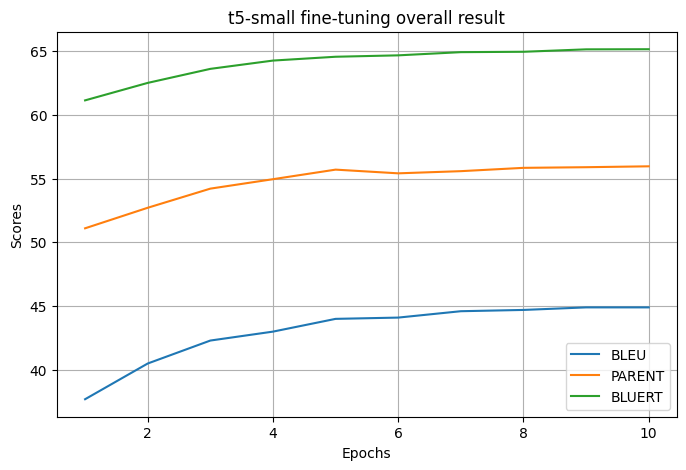

In [2]:
import matplotlib.pyplot as plt

epochs = [i for i in range(1, 11)]
bleu_scores = [37.7, 40.5, 42.3, 43.0, 44.0, 44.1, 44.6, 44.7, 44.9, 44.9]
parent_scores = [51.10, 52.71, 54.21, 54.95, 55.70, 55.41, 55.58, 55.84, 55.89, 55.96]
bluert_scores = [0.6113, 0.6250, 0.6360, 0.6425, 0.6455, 0.6466, 0.6491, 0.6494, 0.6513, 0.6514]

bleurt_scores_scaled = [score * 100 for score in bluert_scores]

plt.figure(figsize=(8, 5))
plt.plot(epochs, bleu_scores, label='BLEU')
plt.plot(epochs, parent_scores, label='PARENT')
plt.plot(epochs, bleurt_scores_scaled, label='BLUERT')
plt.xlabel('Epochs')
plt.ylabel('Scores')
plt.title('t5-small fine-tuning overall result')
plt.legend()
plt.grid(True)
plt.show()

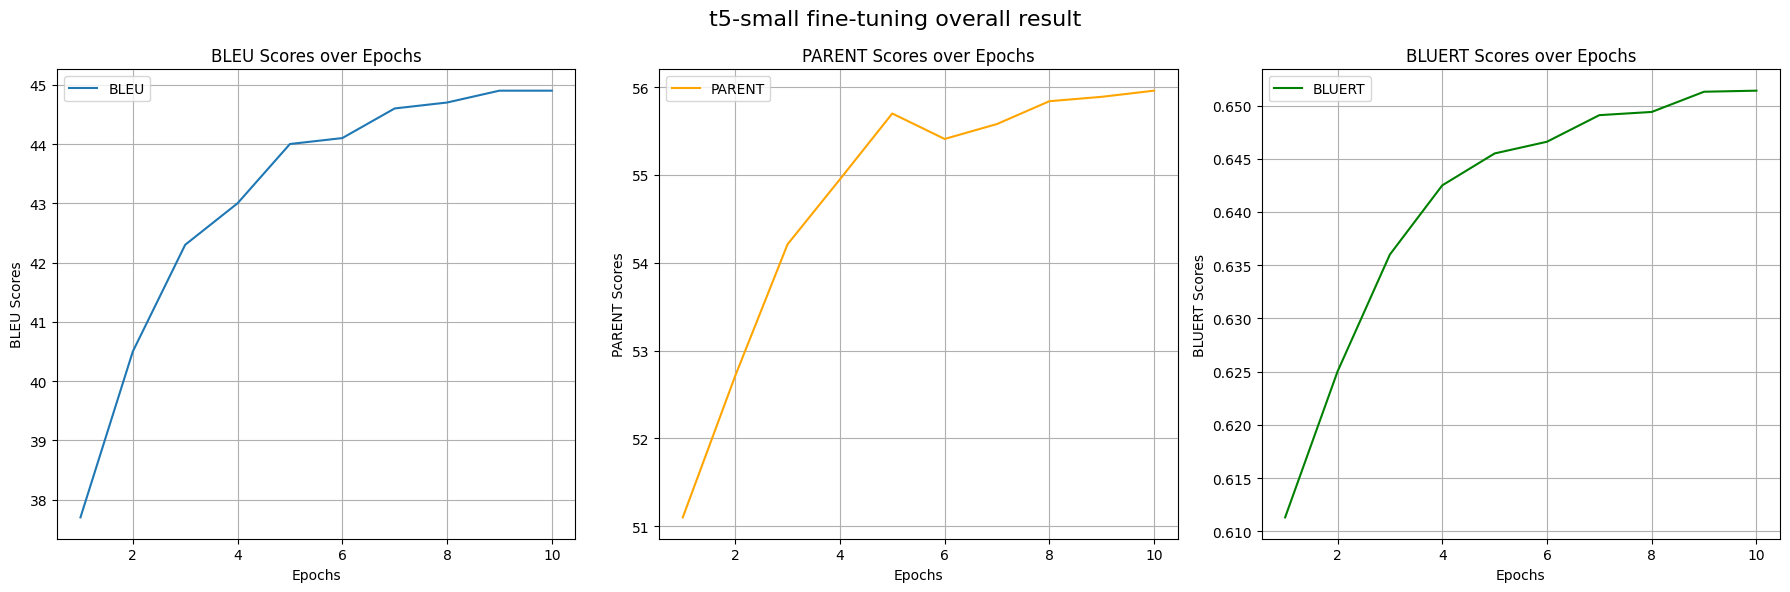

In [3]:
plt.figure(figsize=(18, 6))

# BLEU
plt.subplot(1, 3, 1)
plt.plot(epochs, bleu_scores, label='BLEU')
plt.xlabel('Epochs')
plt.ylabel('BLEU Scores')
plt.title('BLEU Scores over Epochs')
plt.legend()
plt.grid(True)

# PARENT
plt.subplot(1, 3, 2)
plt.plot(epochs, parent_scores, label='PARENT', color='orange')
plt.xlabel('Epochs')
plt.ylabel('PARENT Scores')
plt.title('PARENT Scores over Epochs')
plt.legend()
plt.grid(True)

# BLUERT
plt.subplot(1, 3, 3)
plt.plot(epochs, bluert_scores, label='BLUERT', color='green')
plt.xlabel('Epochs')
plt.ylabel('BLUERT Scores')
plt.title('BLUERT Scores over Epochs')
plt.legend()
plt.grid(True)

plt.suptitle('t5-small fine-tuning overall result', fontsize=16)
plt.tight_layout()
plt.show()